In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from time import time
from icecream import ic

from msfm.utils import tfrecords, analysis, parameters
from msfm import fiducial_pipeline
from msfm.utils.input_output import read_yaml

In [12]:
params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]

fiducial_dset = fiducial_pipeline.get_fiducial_dset(
    tfr_pattern="/cluster/scratch/athomsen/CosmoGrid/debug/v3/fiducial/DESy3_fiducial_???.tfrecord",
    local_batch_size=1,
    params=params,
    i_noise=0,
    n_readers=1,
    examples_shuffle_buffer=1,
)

23-04-28 10:36:37 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-04-28 10:36:37  analysis.py INF   Loaded the config 
23-04-28 10:36:37  analysis.py INF   Loaded the config 
23-04-28 10:36:37  analysis.py INF   Loaded the config 
23-04-28 10:36:37  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-28 10:36:37  analysis.py INF   Loaded the pixel file 
23-04-28 10:36:37  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-28 10:36:37  analysis.py INF   Loaded the pixel file 
23-04-28 10:36:37 fiducial_pip INF   Shuffling file names 
23-04-28 10:36:37 tfrecords.py WAR   Tracing parse_inverse_fiducial 
23-04-28 10:36:37 fiducial_pip INF   Batching into 1 elements locally 
23-04-28 10:36:37 fiducial_pip WAR   Tracing dset_augmentations 
23-04-28 10:36:37 fiducial_pip INF   Succ

In [13]:
for data_vectors, index in fiducial_dset.take(1):
    print(data_vectors.shape)

(13, 475136, 10)


In [14]:
data_vec_pix, _, _, _ = analysis.load_pixel_file()
n_side = 512
n_pix = hp.nside2npix(n_side)

23-04-28 10:36:46  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-28 10:36:46  analysis.py INF   Loaded the pixel file 


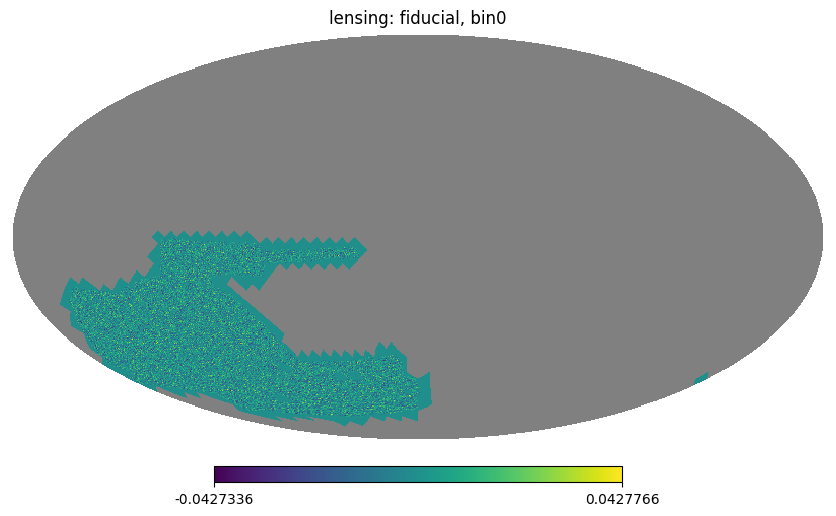

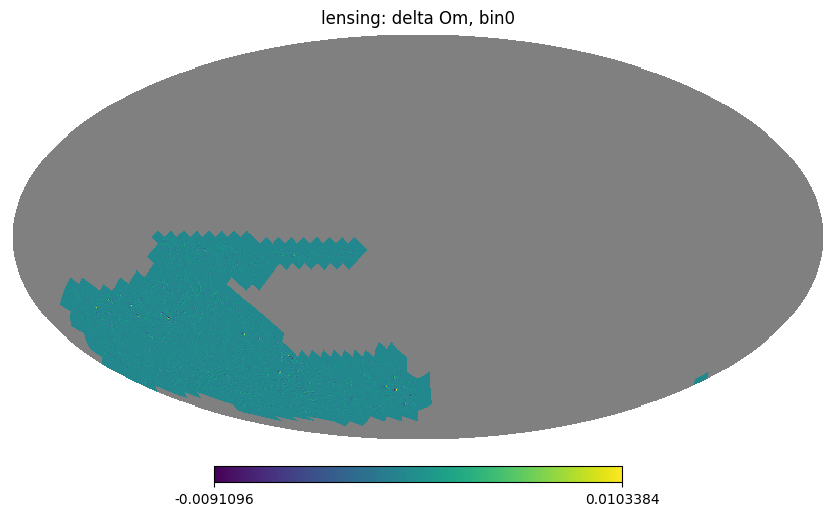

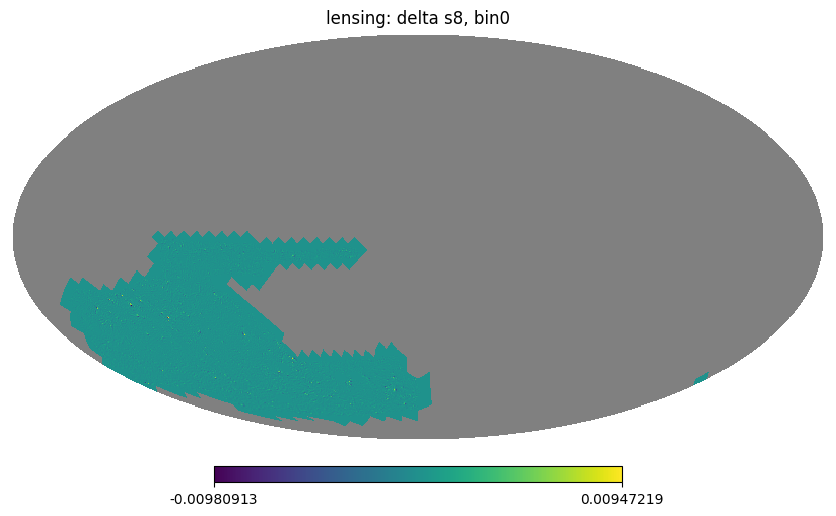

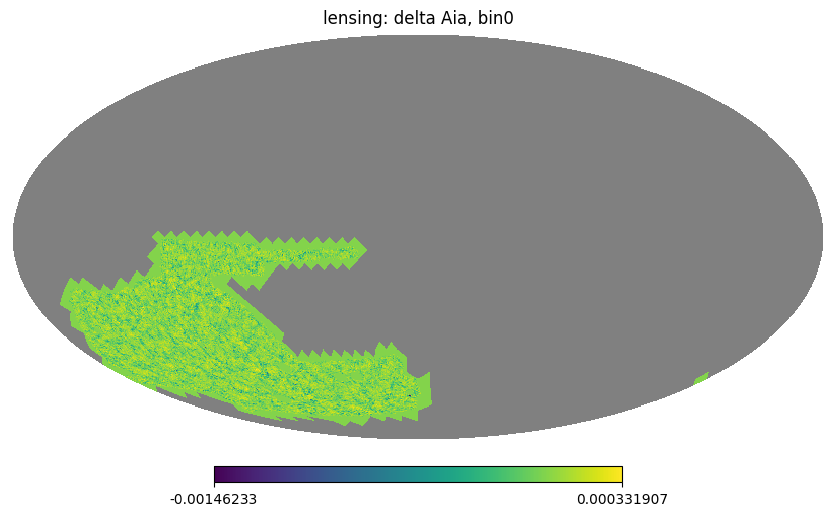

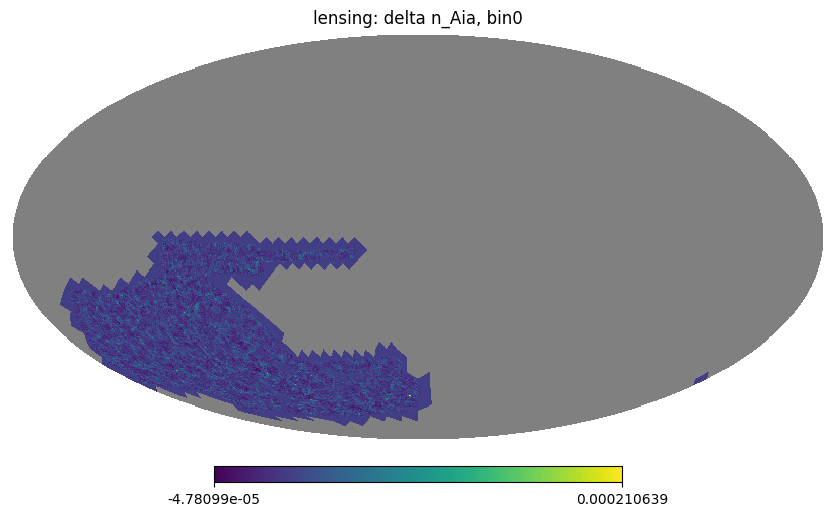

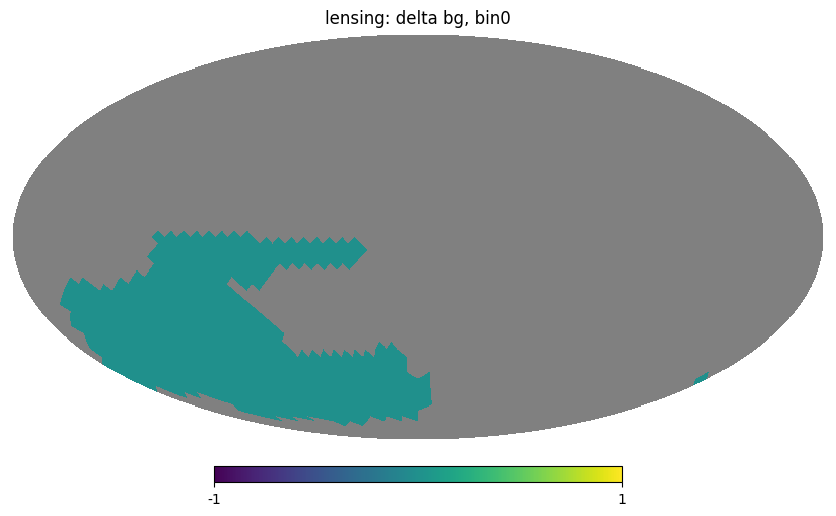

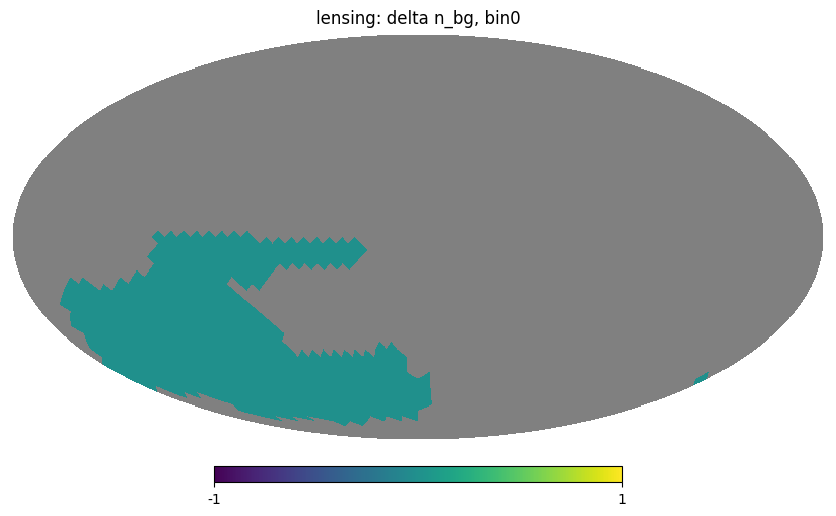

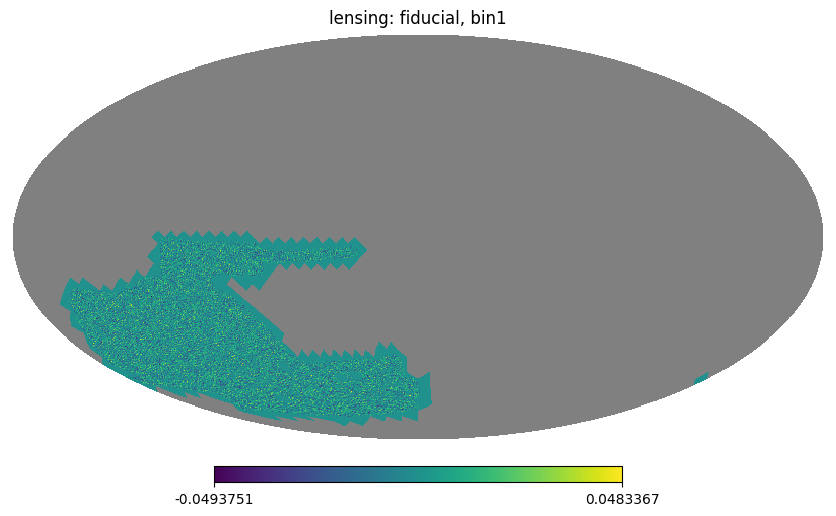

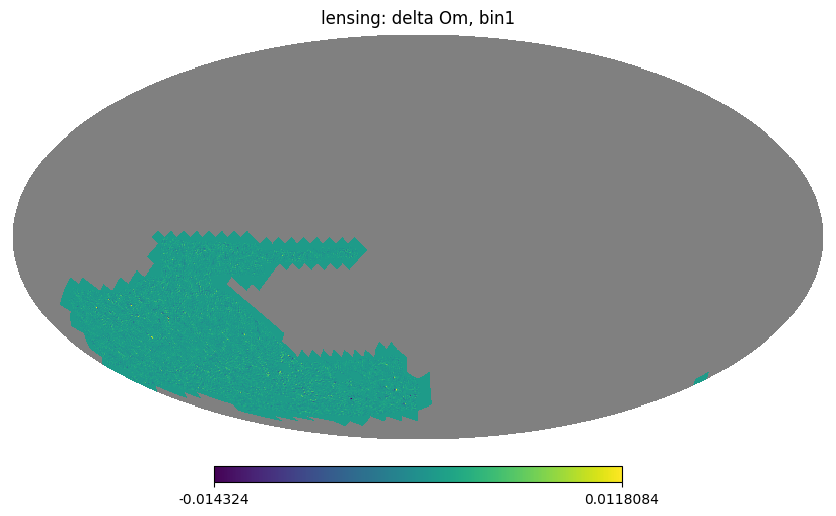

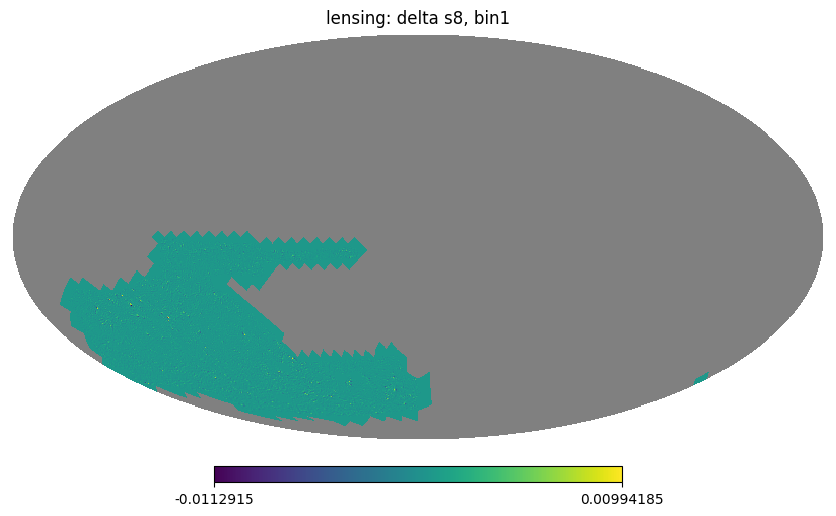

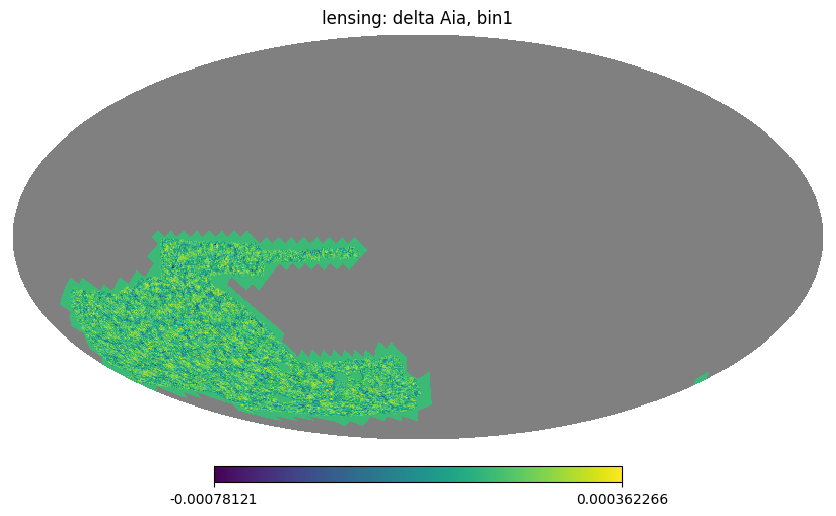

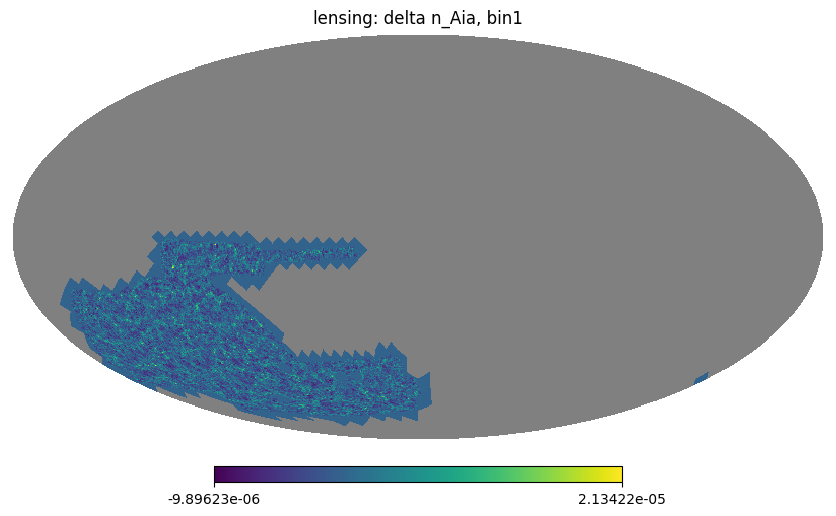

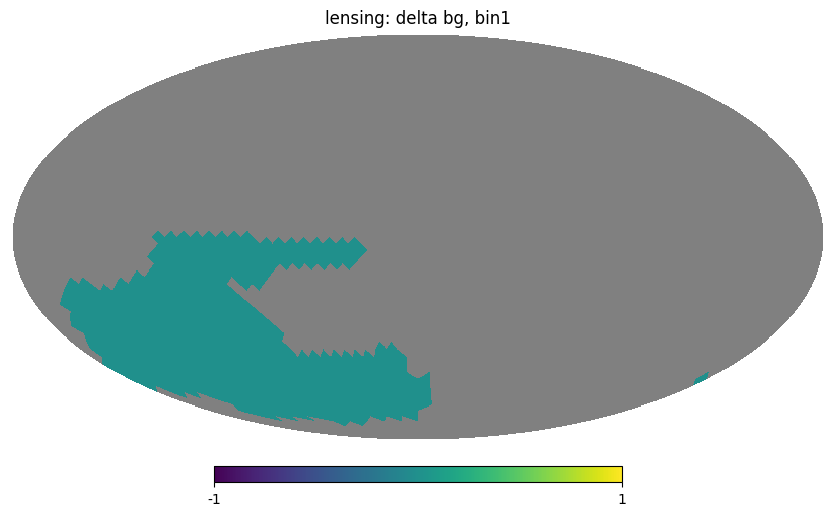

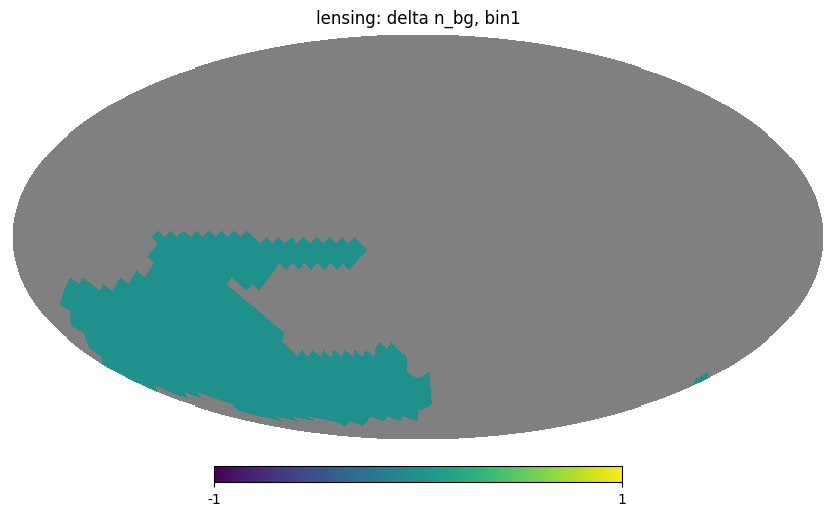

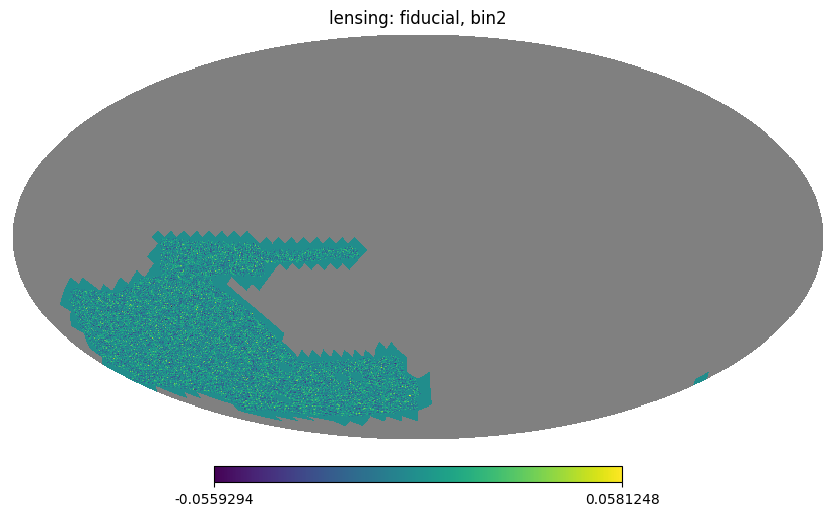

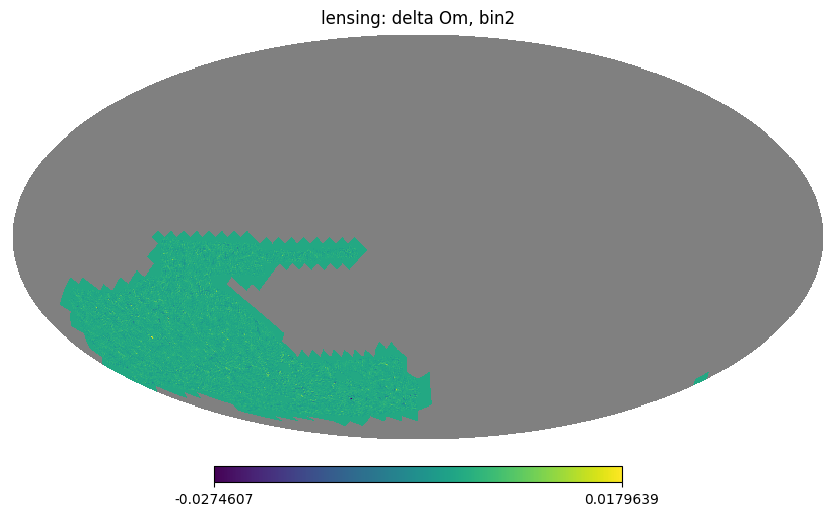

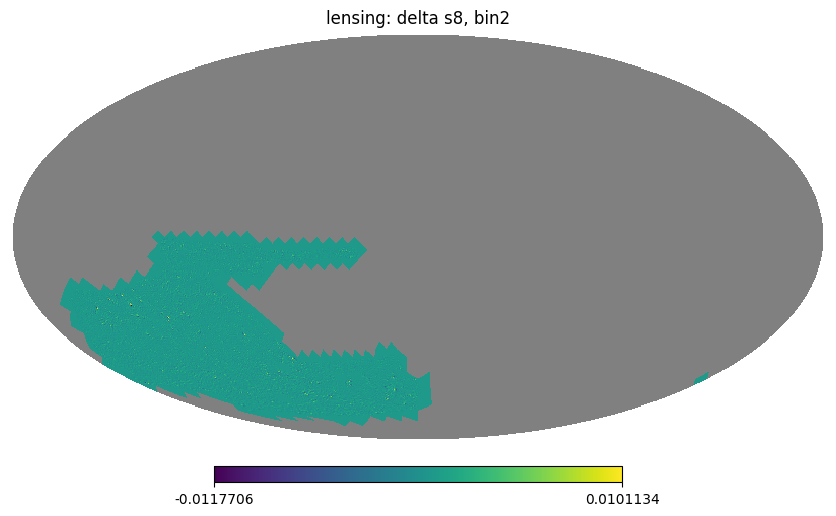

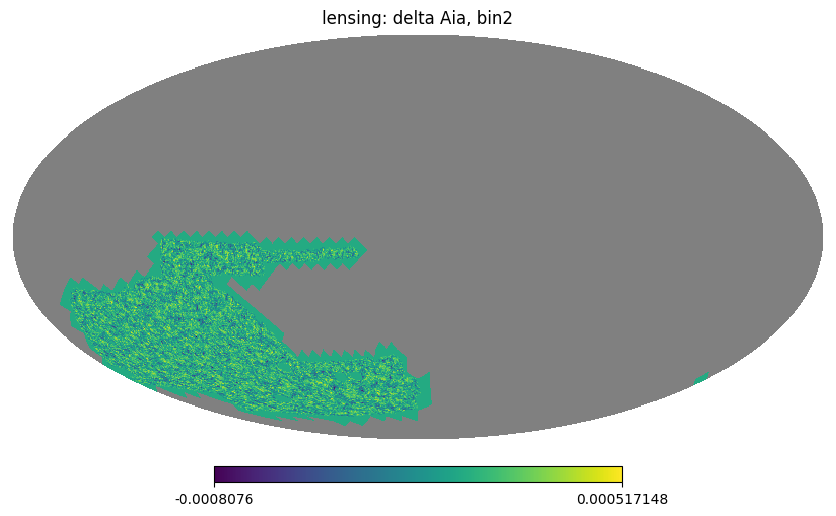

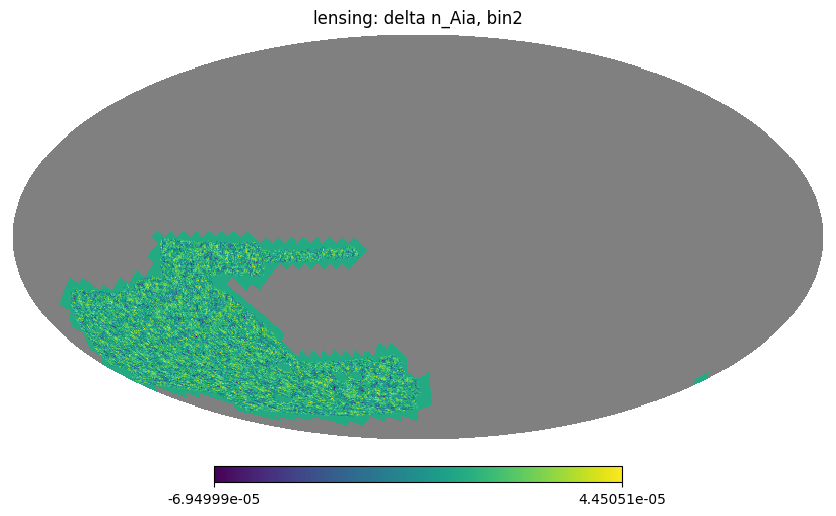

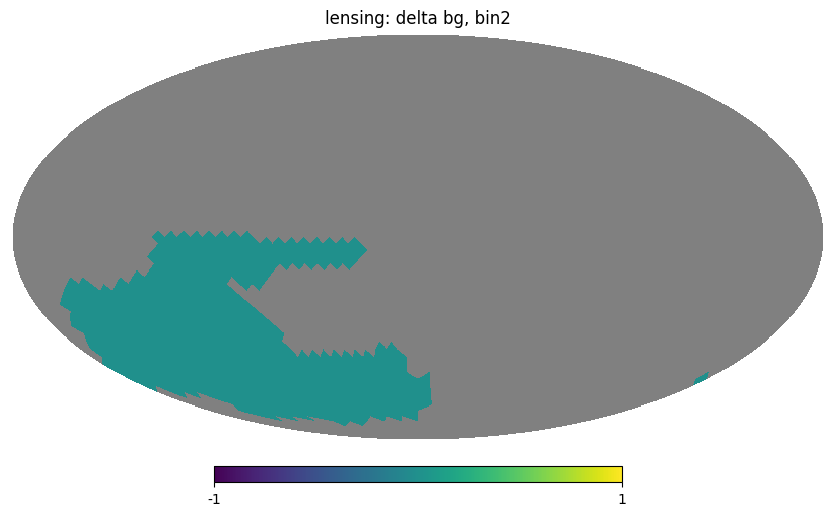

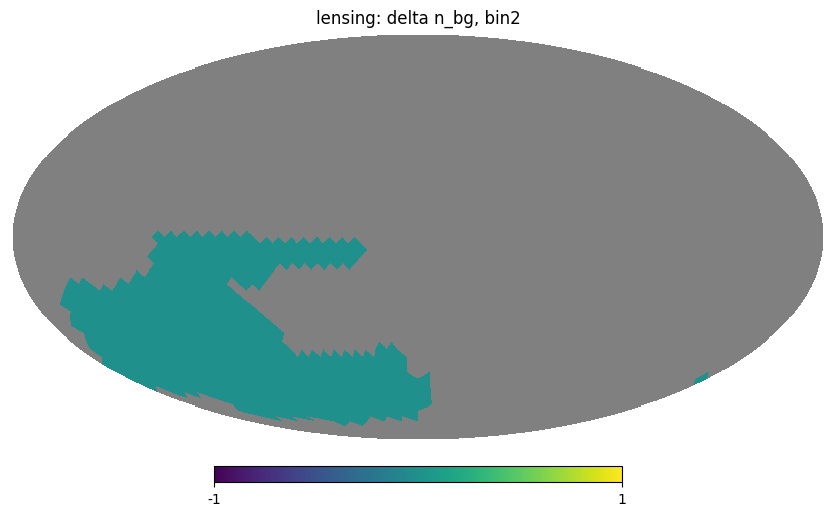

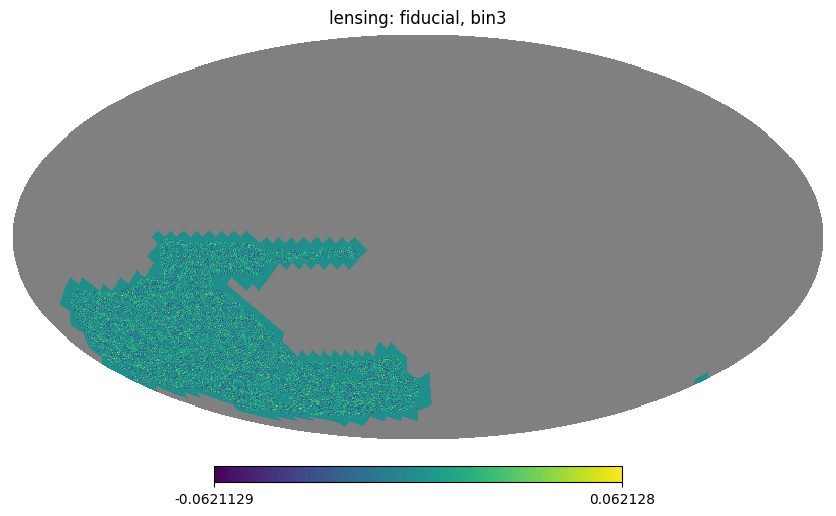

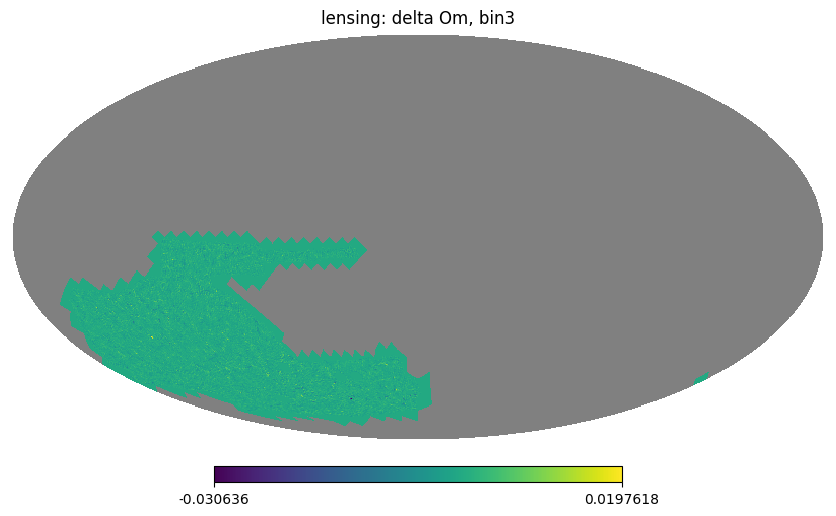

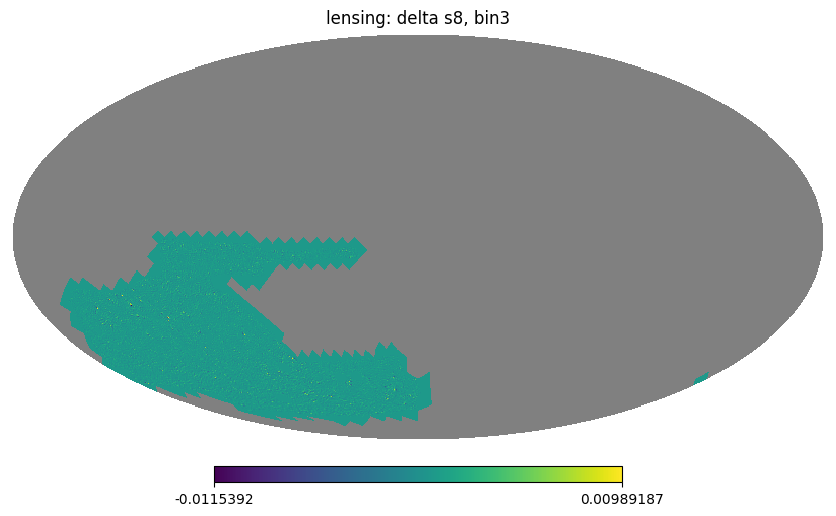

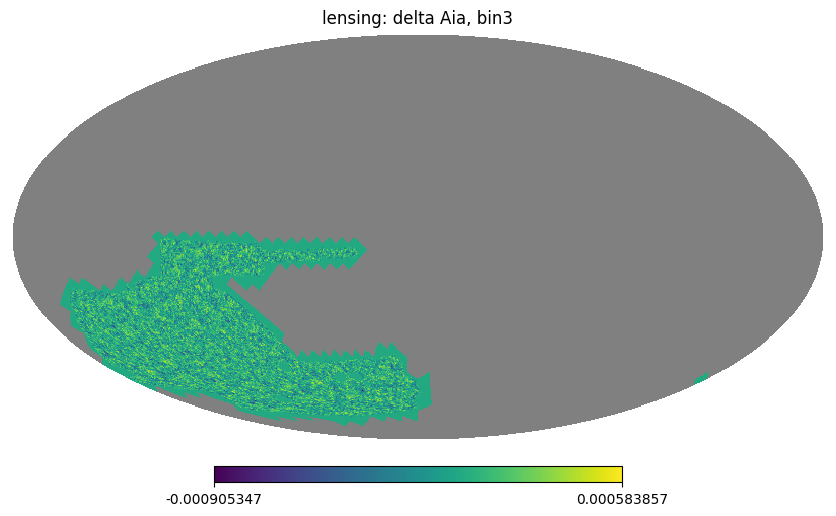

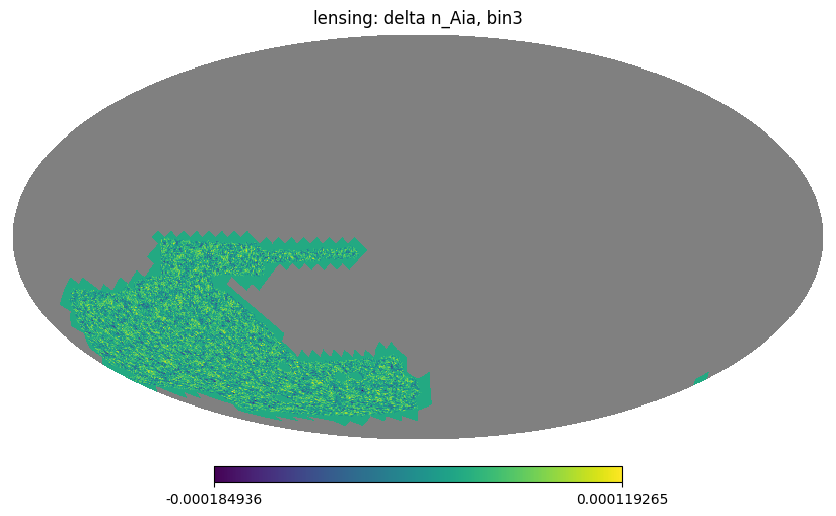

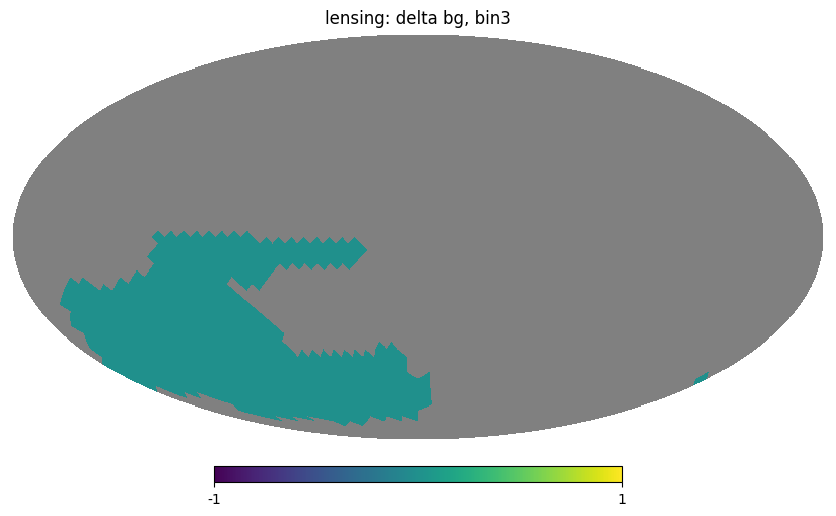

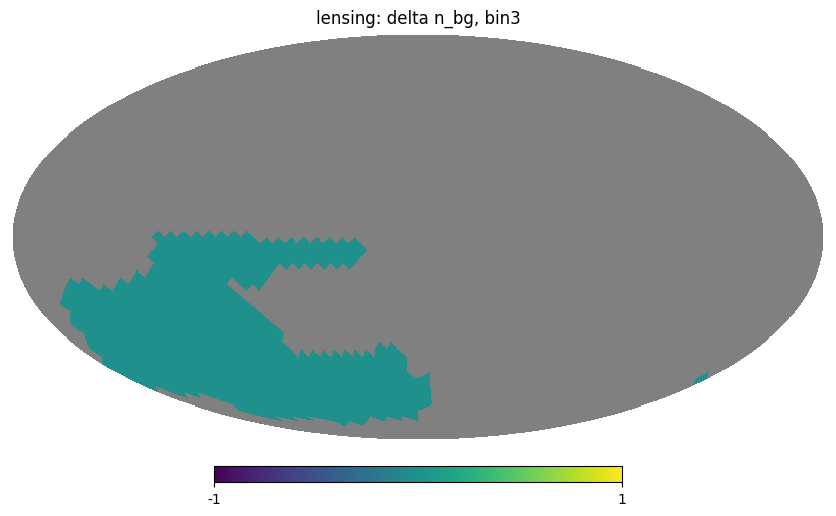

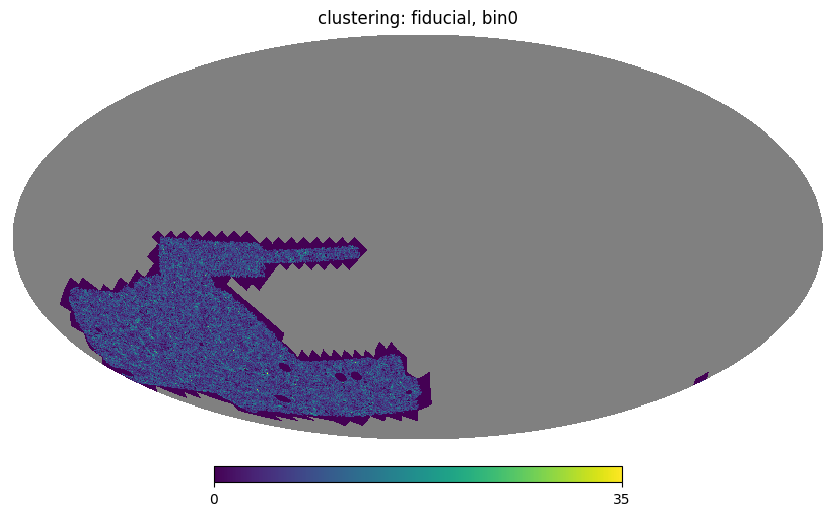

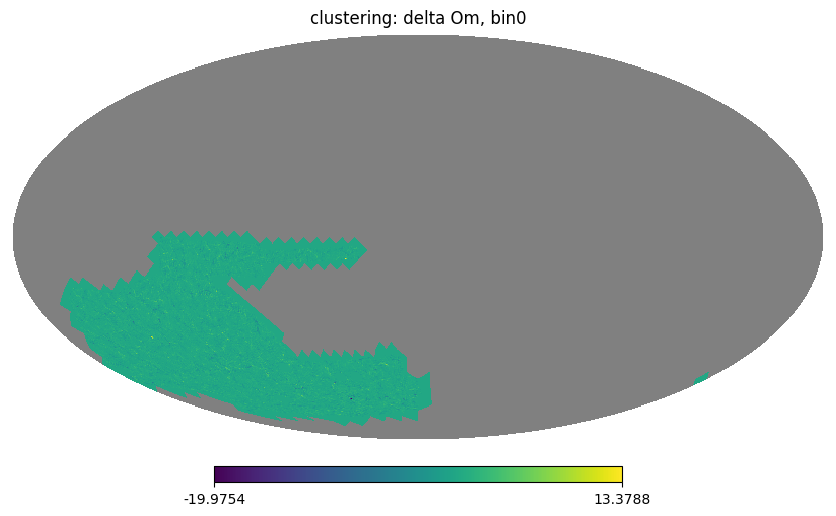

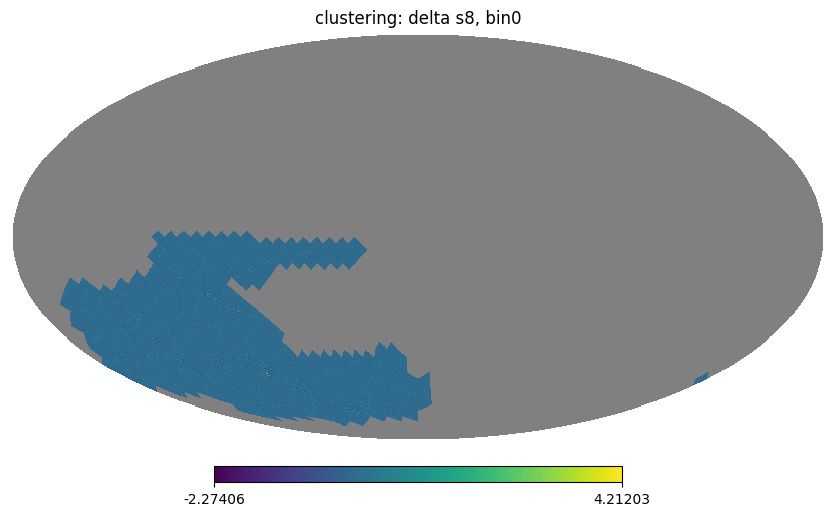

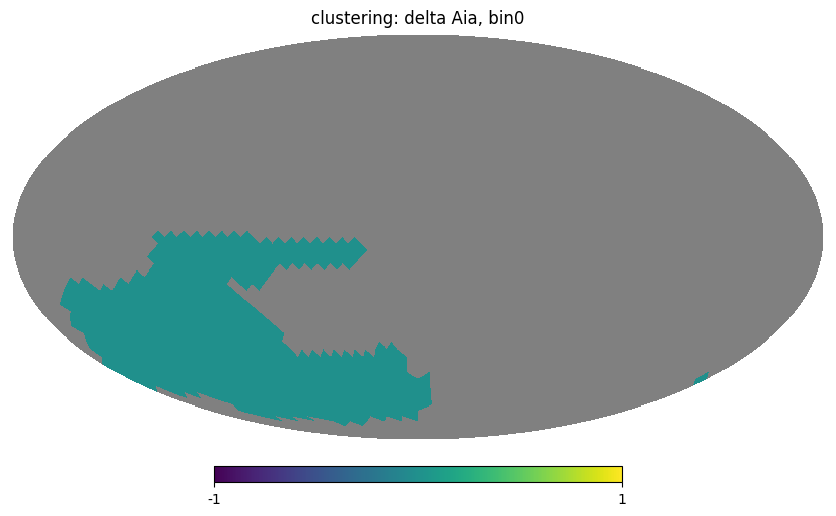

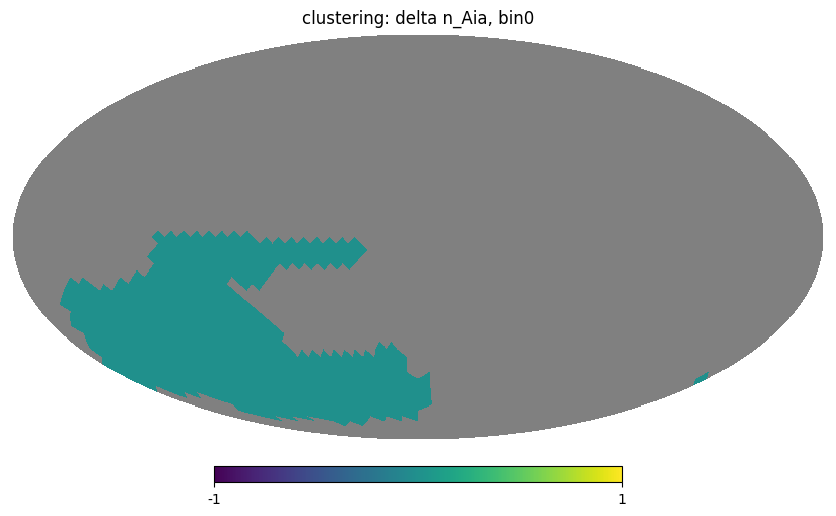

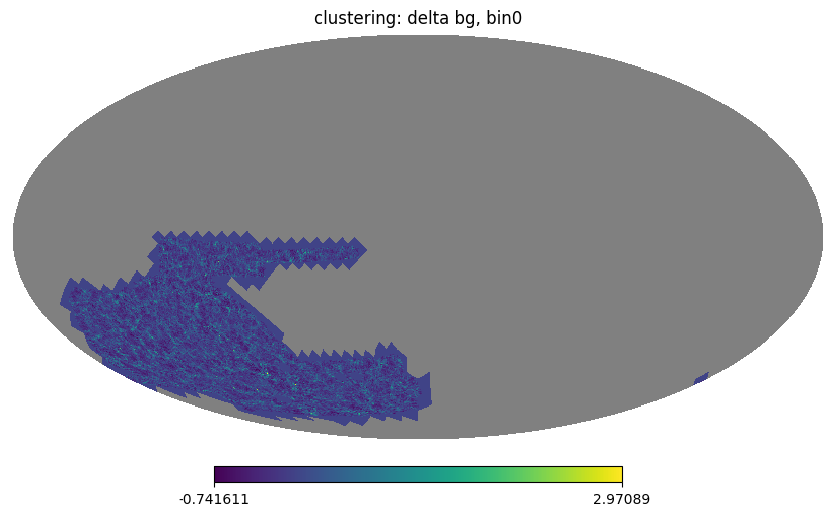

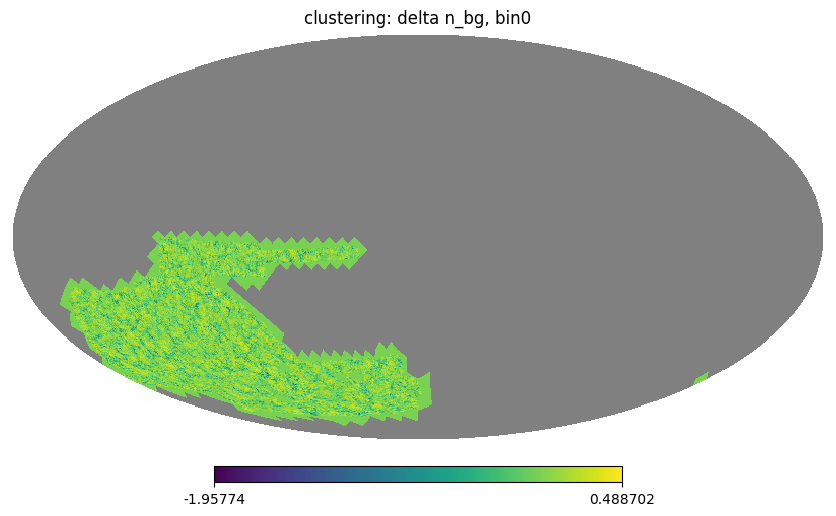

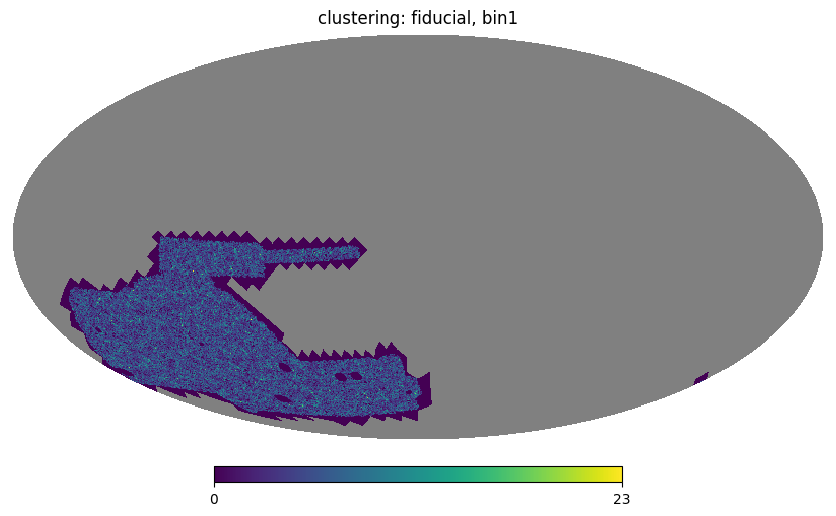

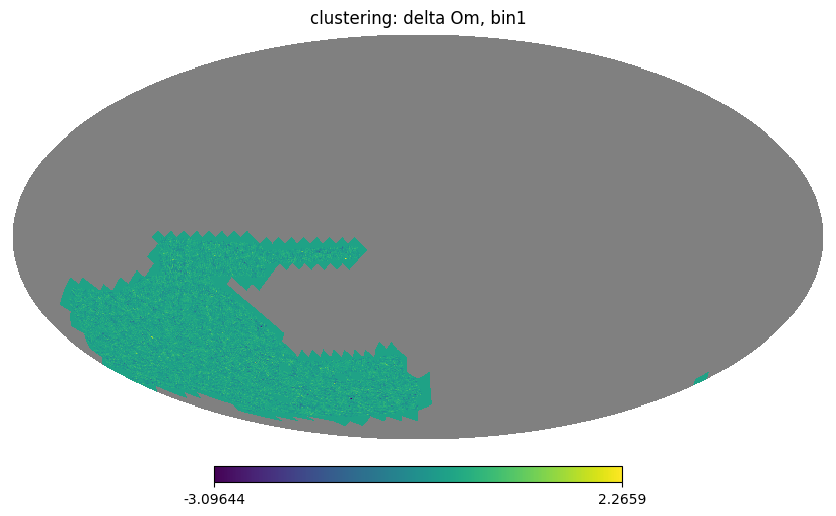

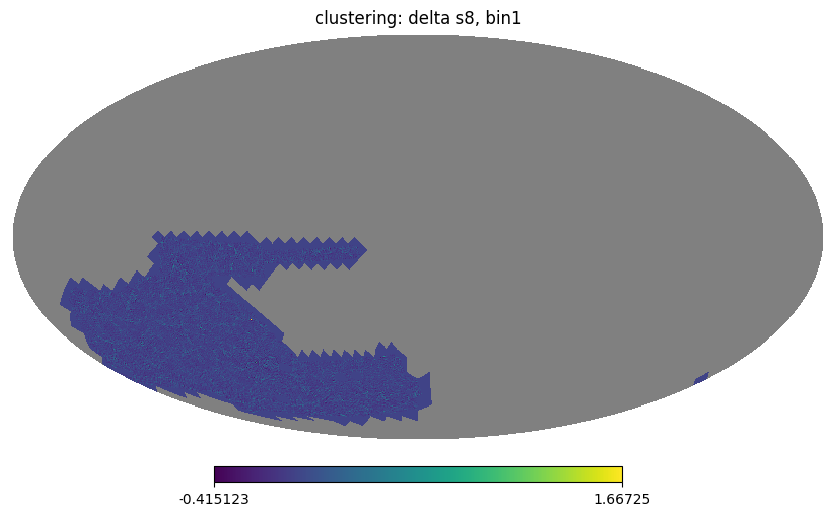

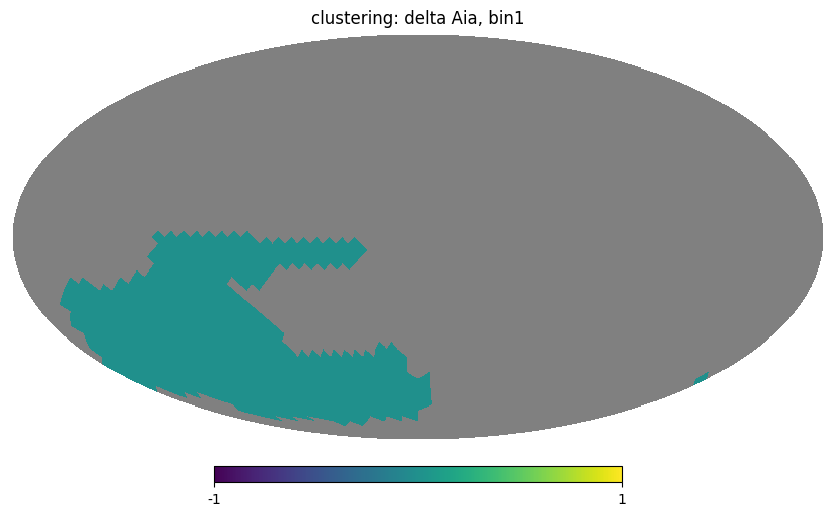

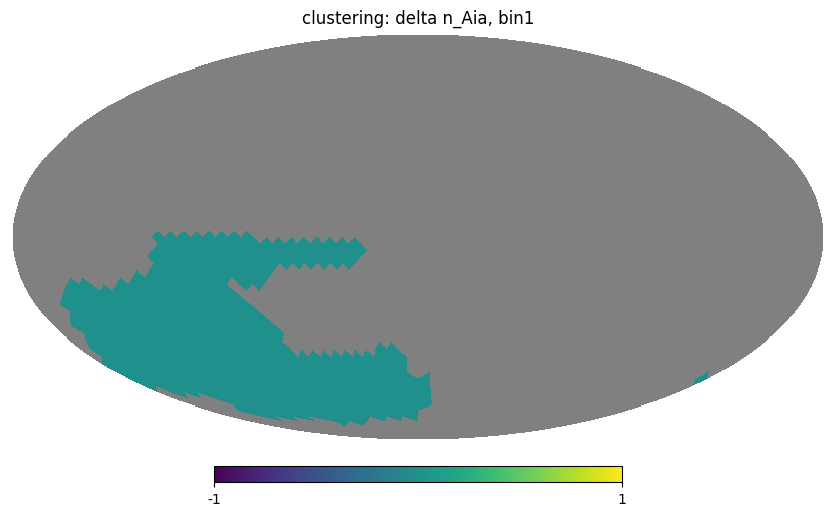

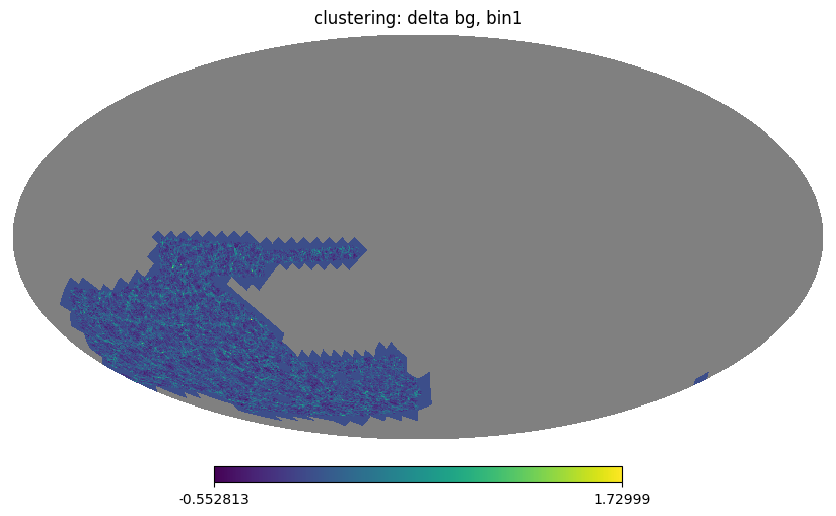

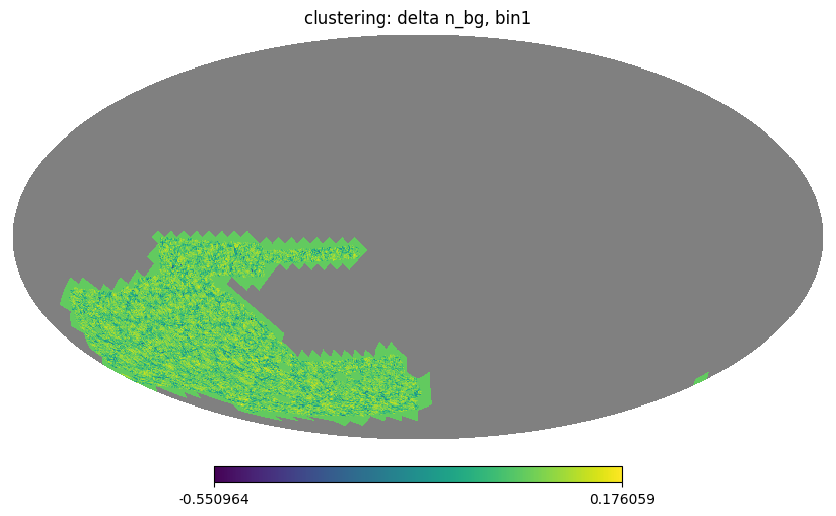

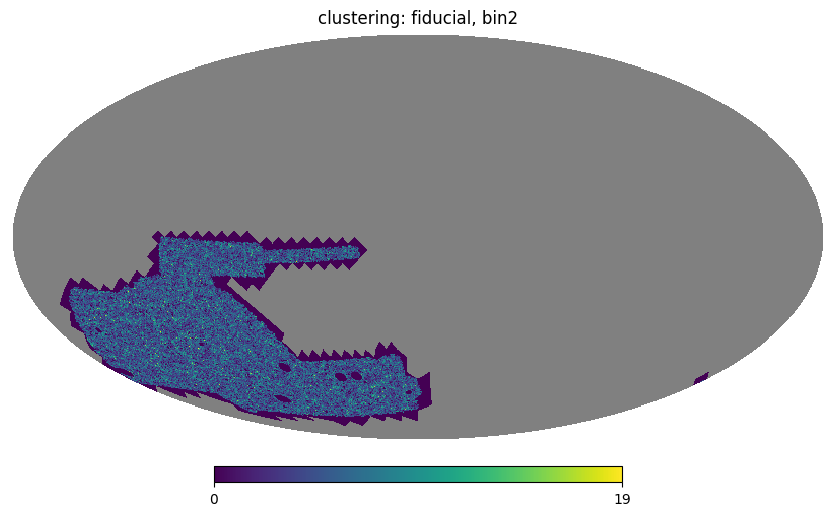

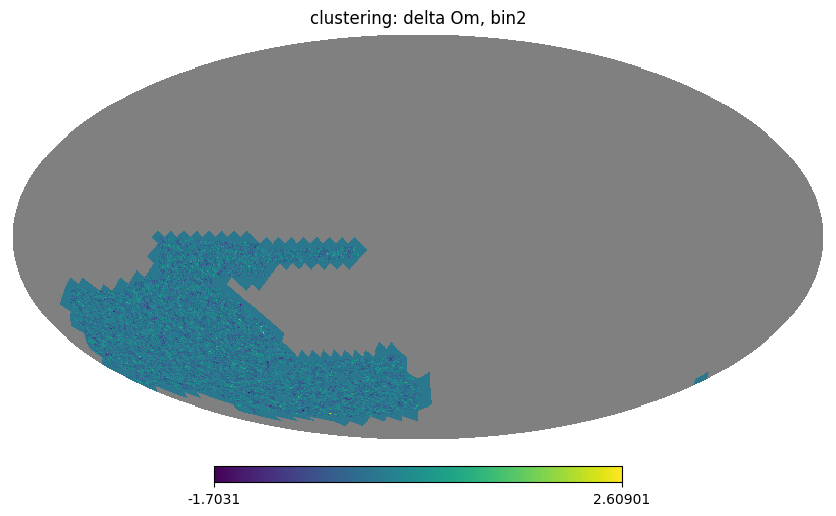

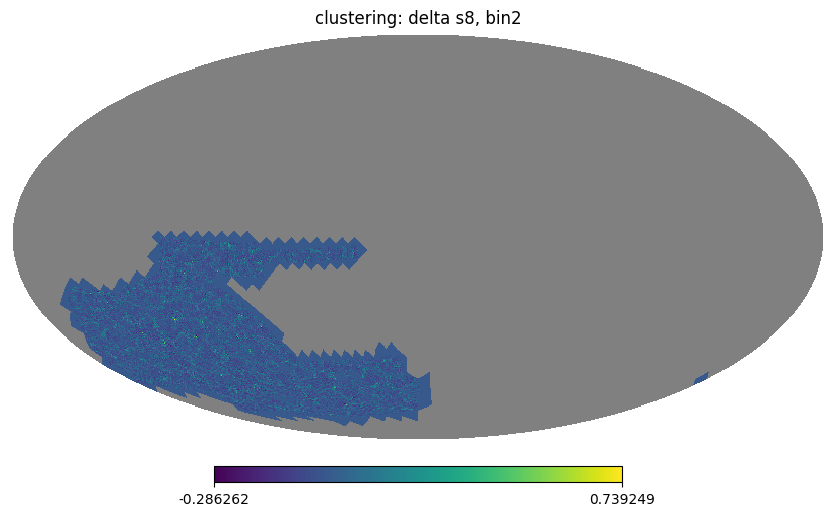

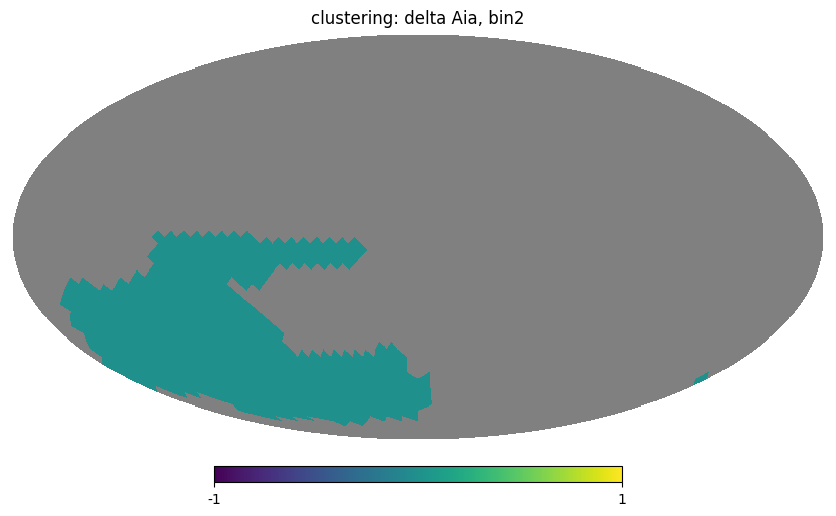

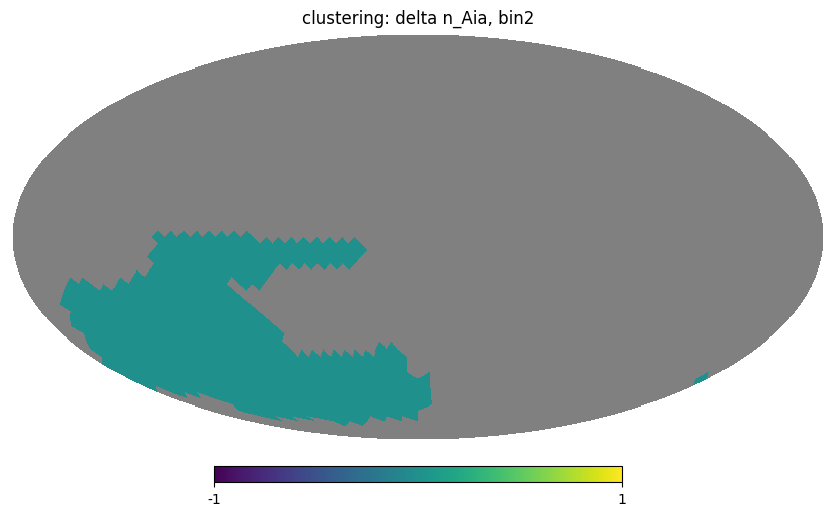

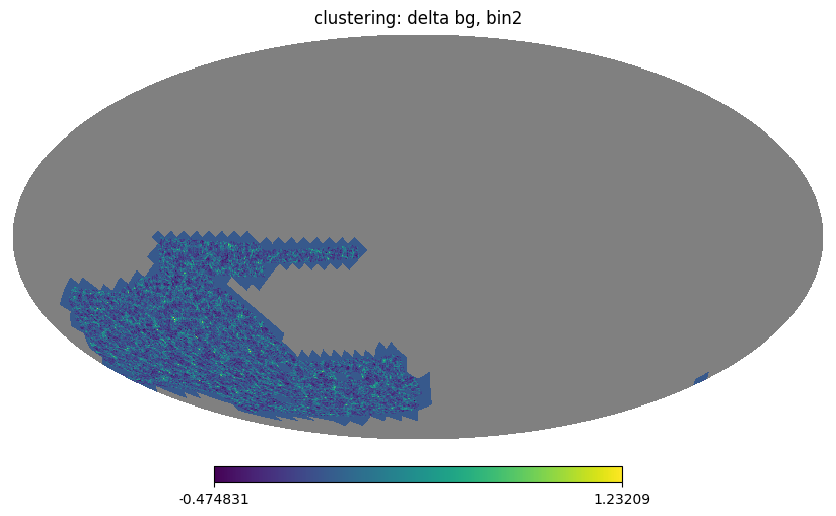

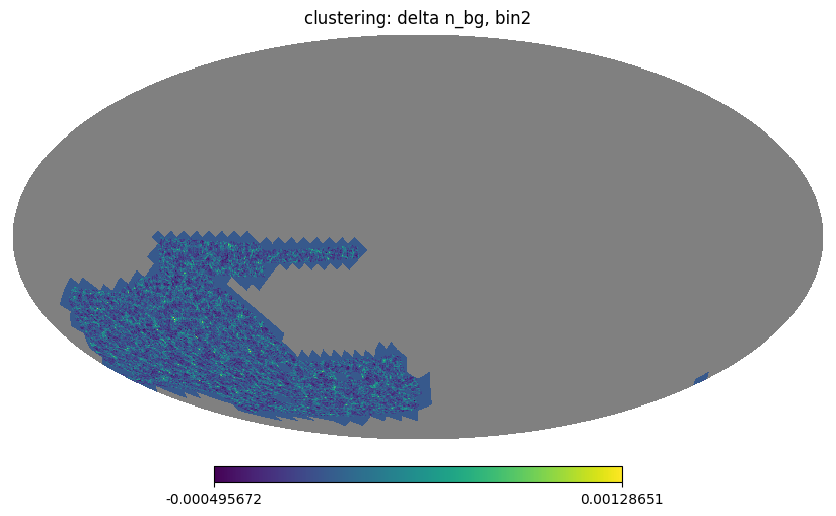

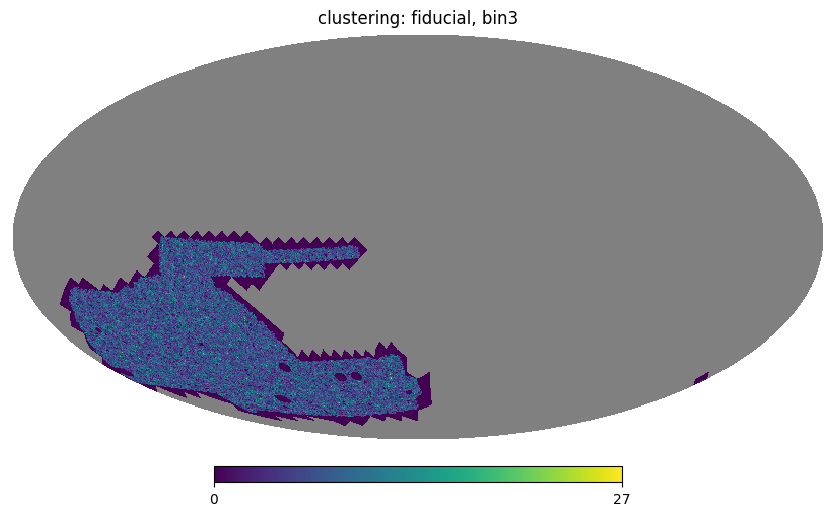

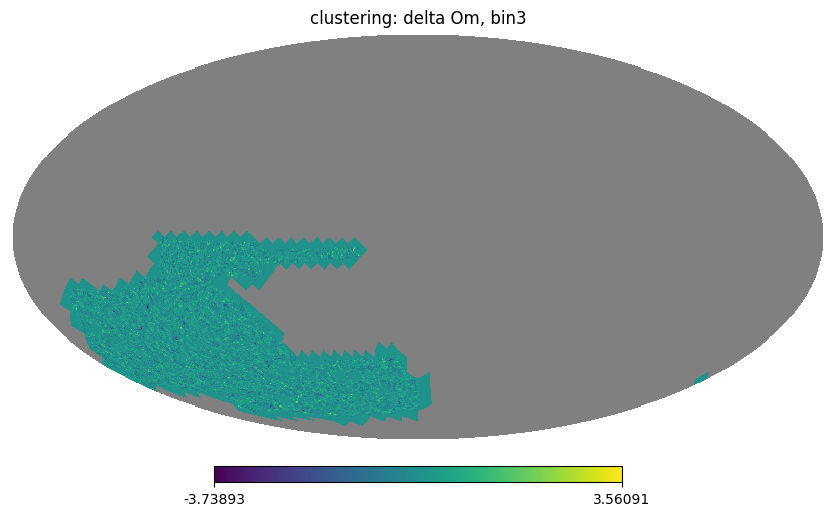

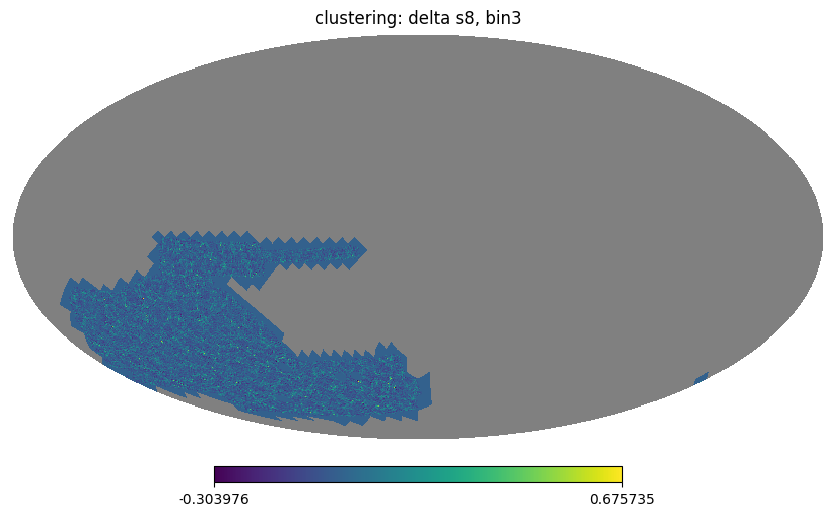

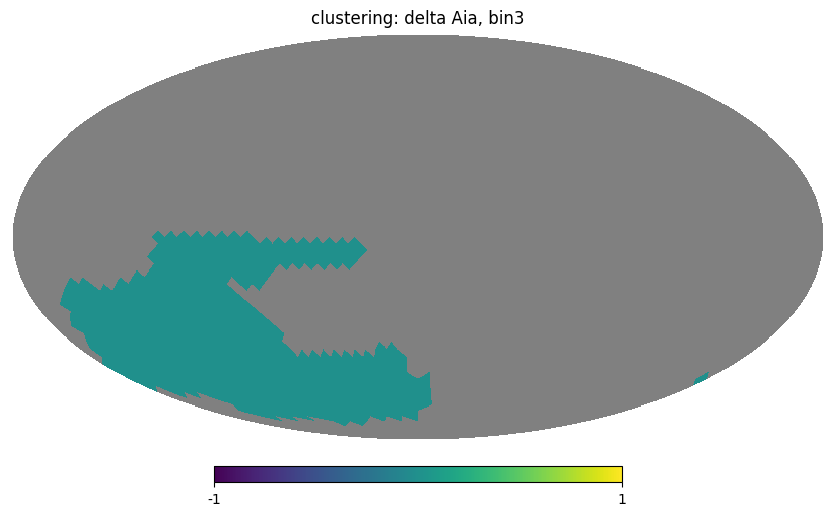

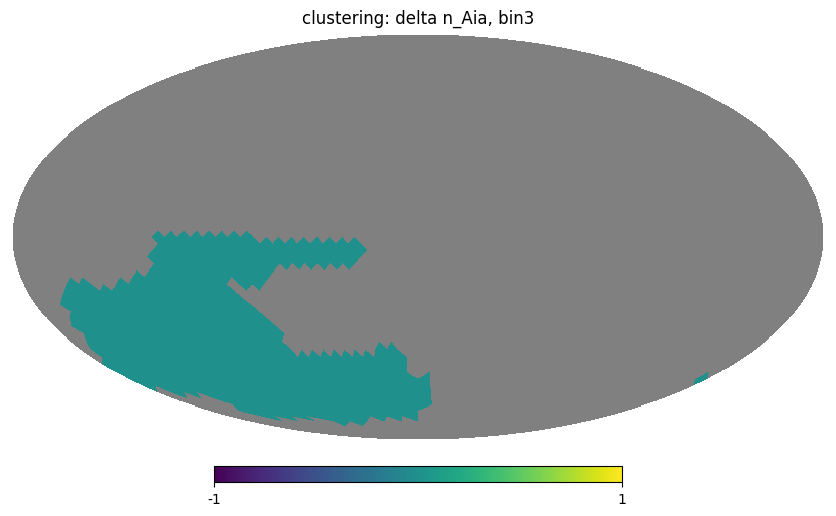

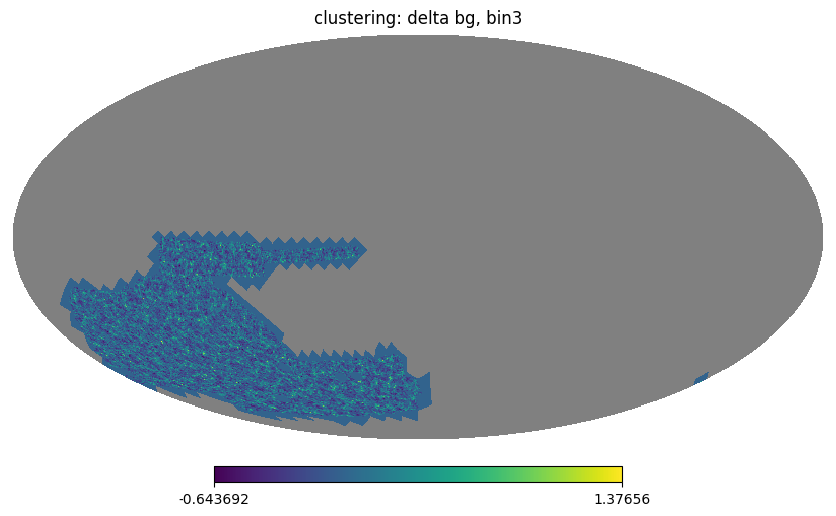

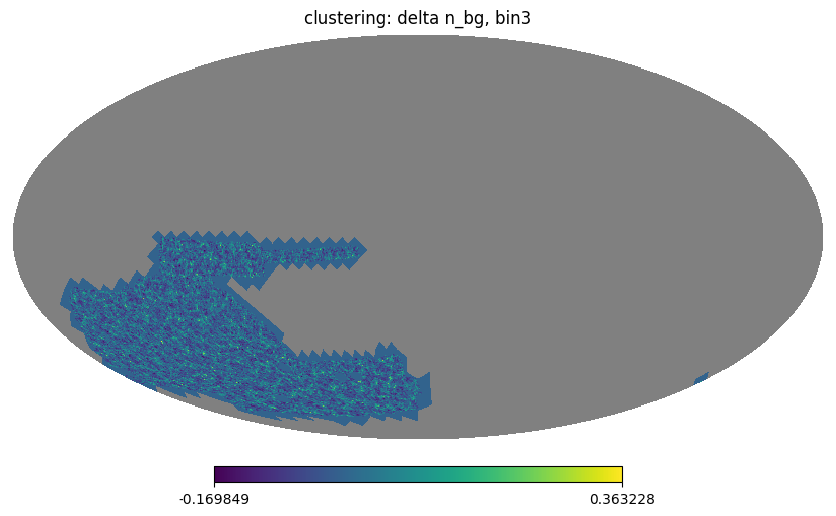

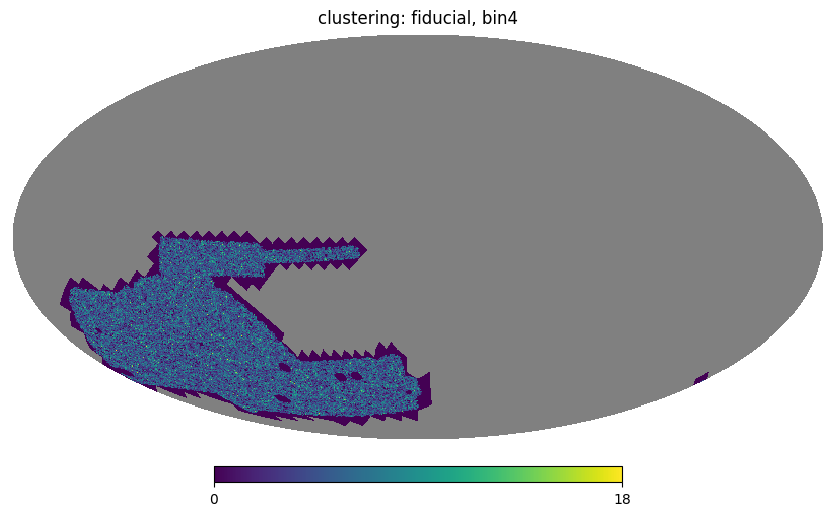

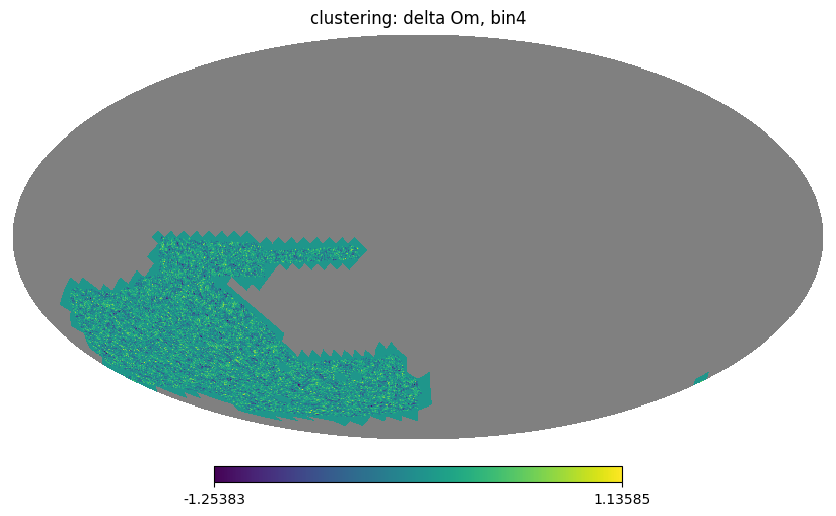

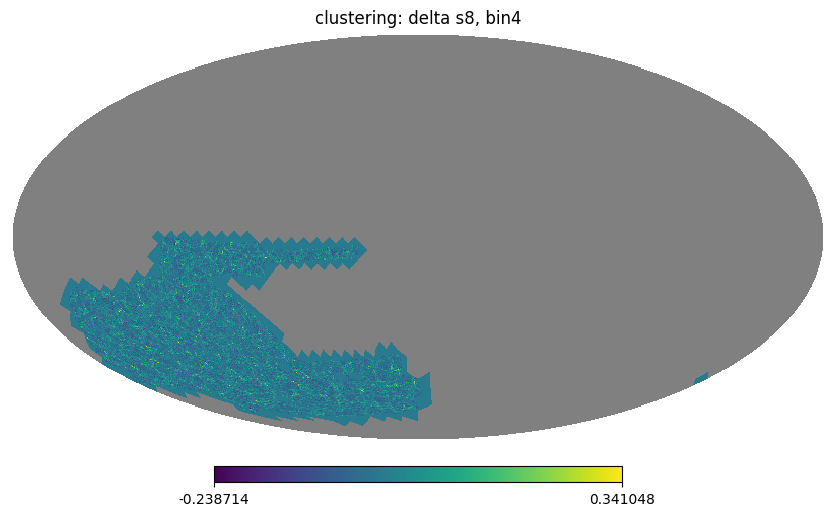

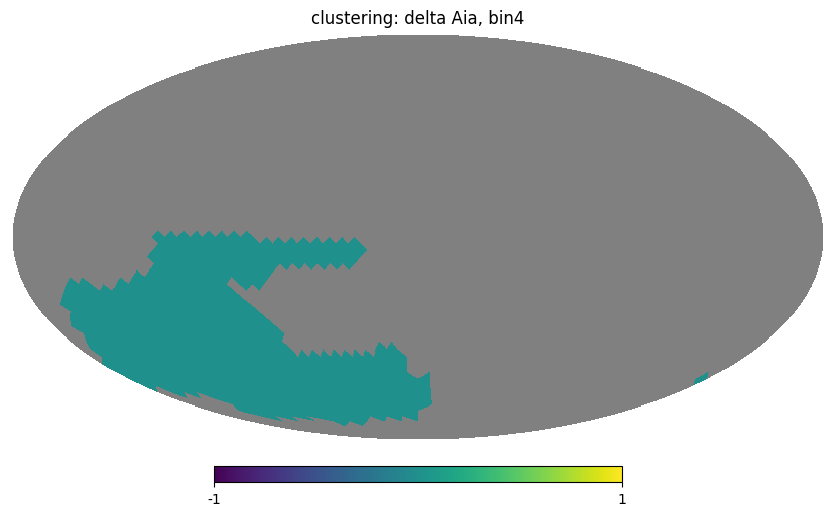

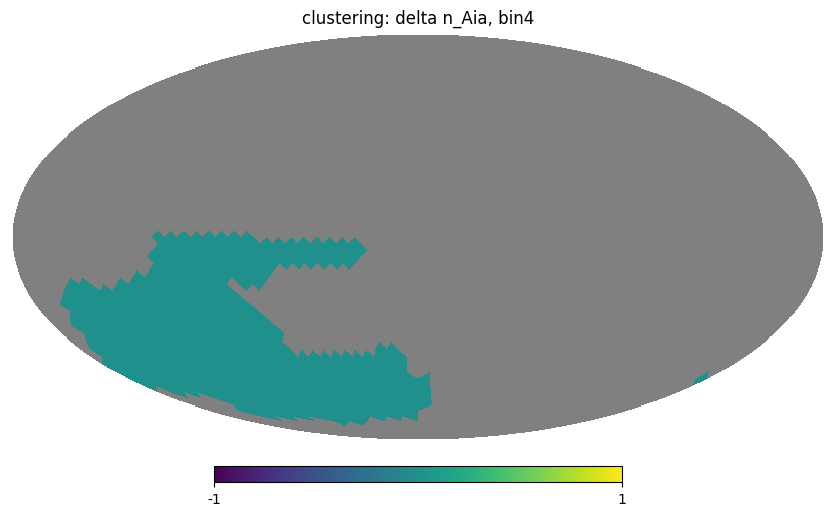

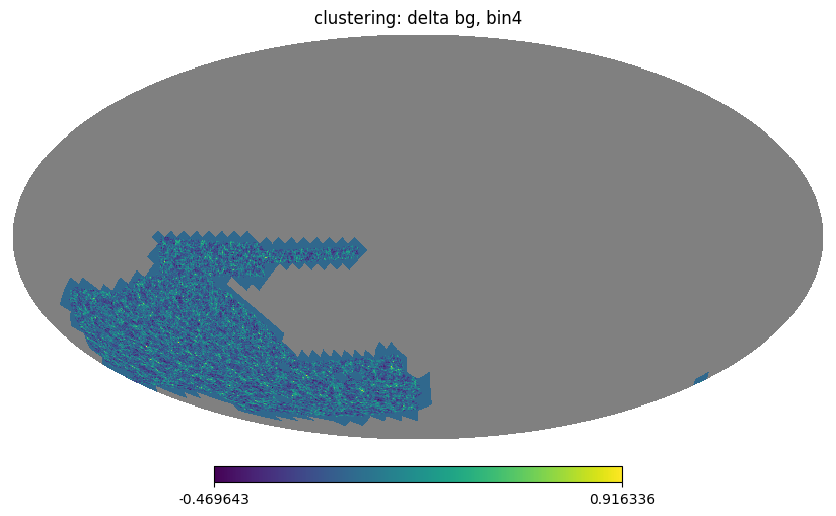

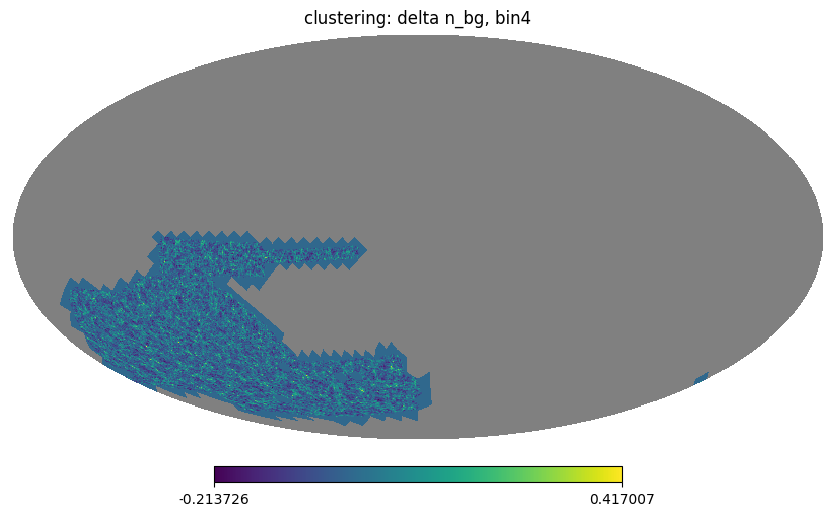

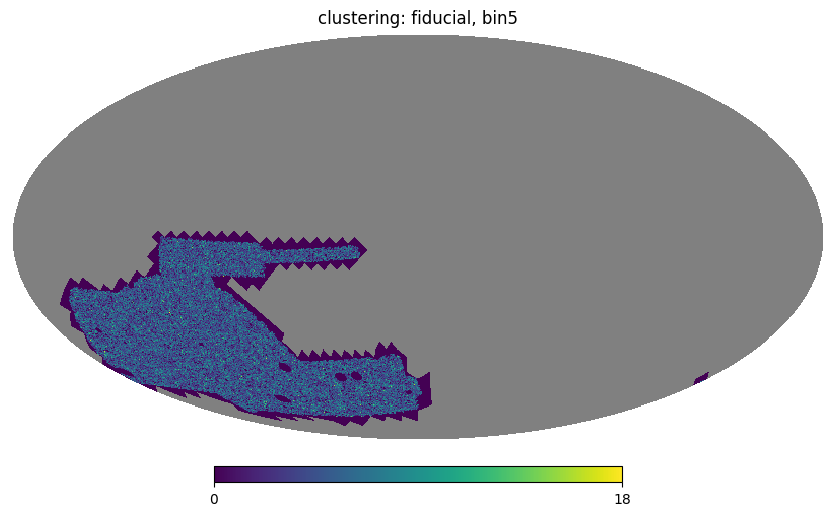

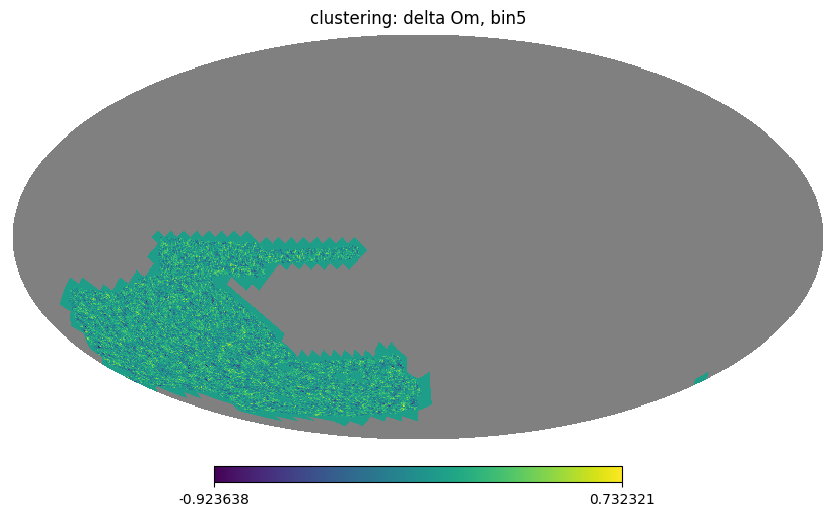

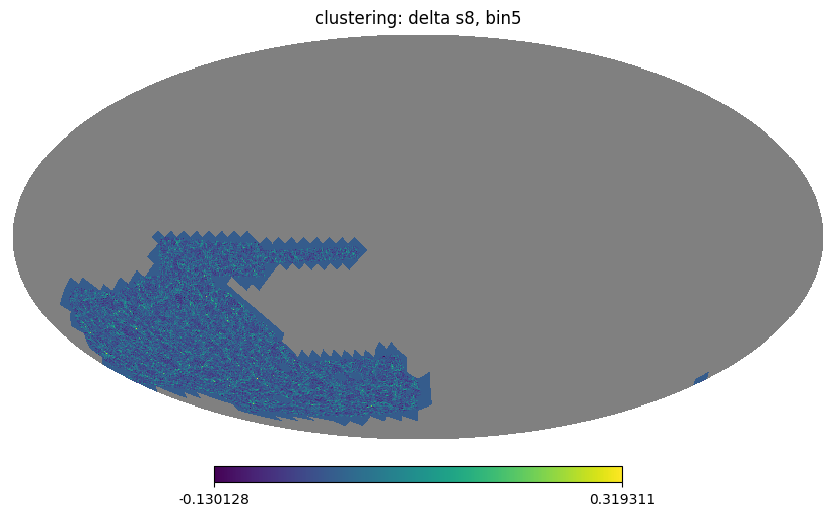

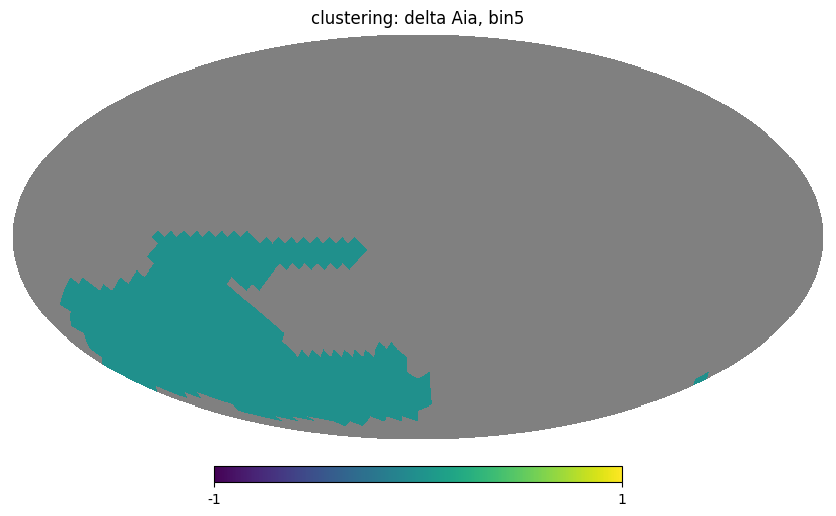

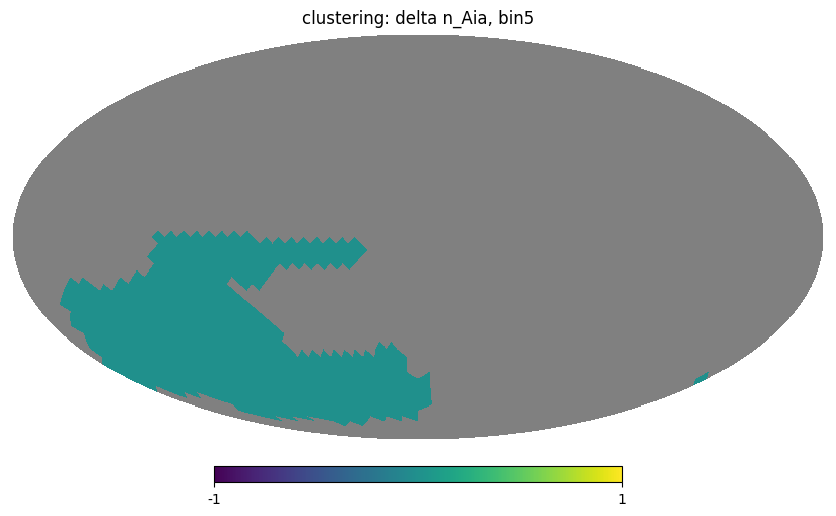

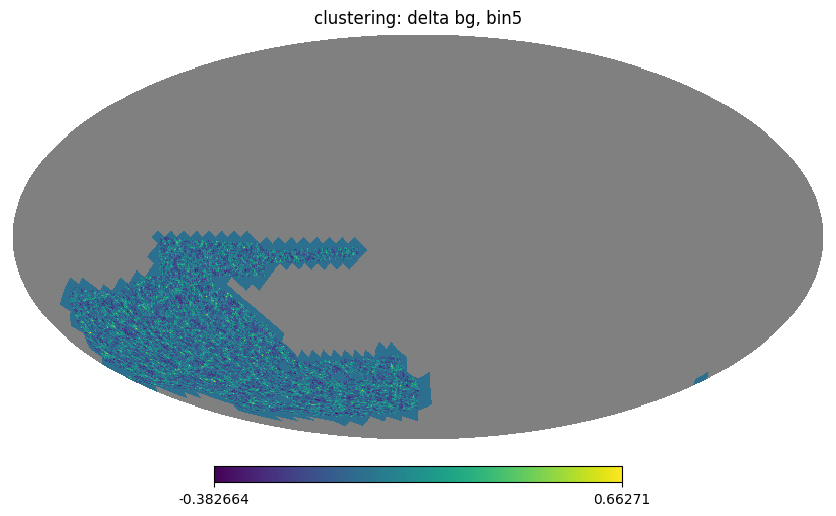

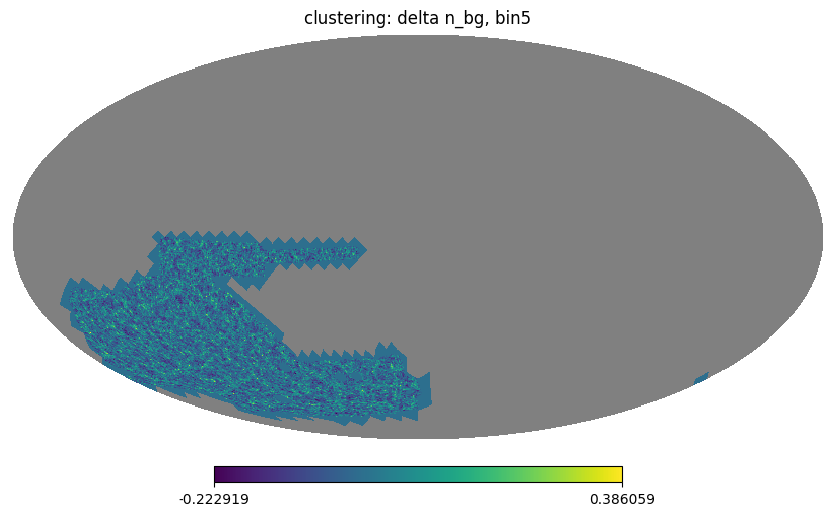

In [15]:
# loop over the tomographic bin/map type
for i in range(10):
    if i < 4:
        map_type = "lensing"
        i_tomo = i
    else:
        map_type = "clustering"
        i_tomo = i - 4
        
    # loop over the parameter perturbation
    for j, param in enumerate(["fiducial"] + params):
        hp_map = np.full(n_pix, hp.UNSEEN)

        if j == 0:
            hp_map[data_vec_pix] = data_vectors[j,:,i]
            hp.mollview(hp_map, nest=True, title=f"{map_type}: fiducial, bin{i_tomo}")
            
        else:
            i_m = 2*j-1
            i_p = 2*j
            # print(f"i_m = {i_m}, i_p = {i_p}")
            # plus - minus perturbation
            hp_map[data_vec_pix] = data_vectors[i_p,:,i] - data_vectors[i_m,:,i]
            hp.mollview(hp_map, nest=True, title=f"{map_type}: delta {param}, bin{i_tomo}")

    

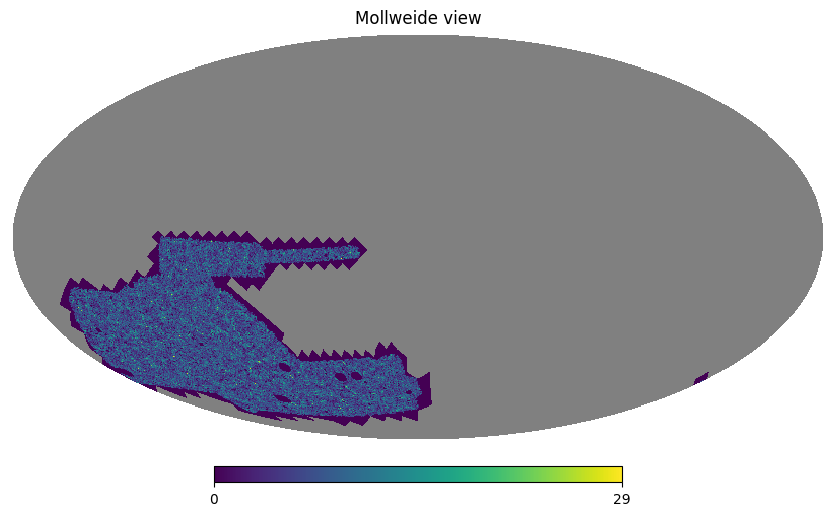

In [104]:
hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = data_vectors[0,:,4]

hp.mollview(hp_map, nest=True)

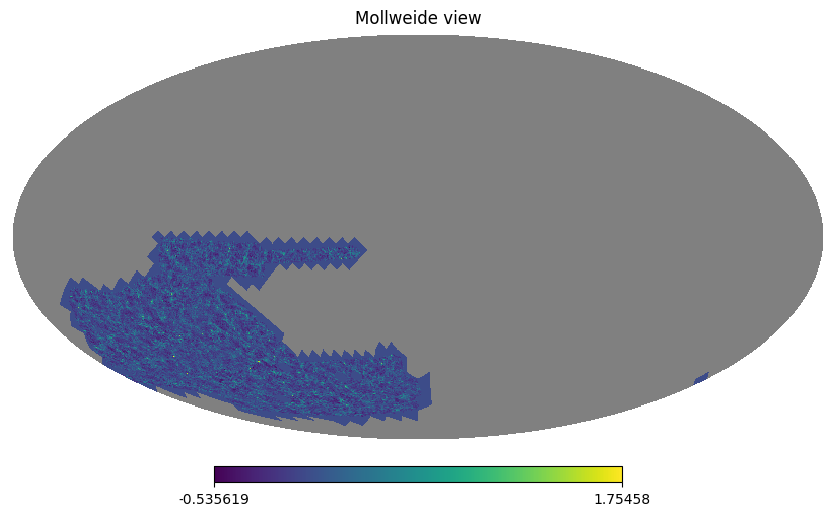

In [106]:
hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = data_vectors[-2,:,4] - data_vectors[-1,:,4]

hp.mollview(hp_map, nest=True)

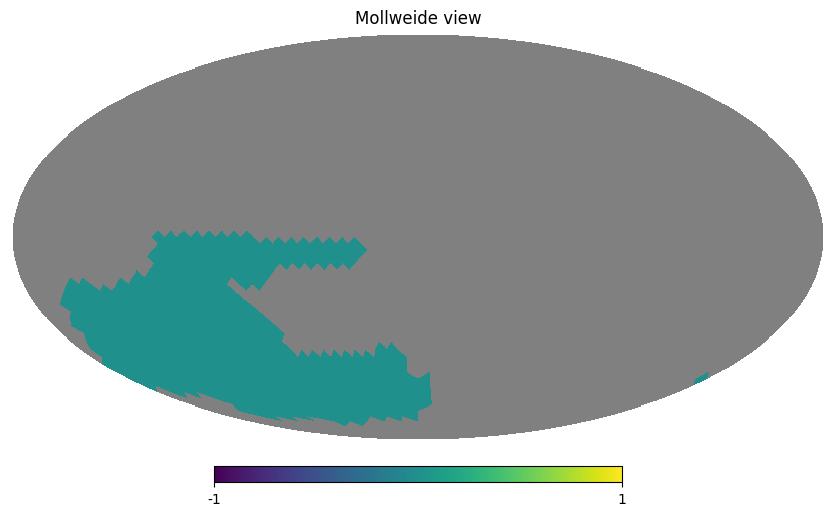

In [105]:
hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = data_vectors[0,:,4] - data_vectors[-5,:,4]

hp.mollview(hp_map, nest=True)

(array([1.00635e+05, 2.16701e+05, 1.38555e+05, 1.69100e+04, 1.95100e+03,
        3.12000e+02, 5.00000e+01, 1.20000e+01, 7.00000e+00, 3.00000e+00]),
 array([ 0.       ,  3.5869262,  7.1738524, 10.760778 , 14.347705 ,
        17.934631 , 21.521557 , 25.108484 , 28.69541  , 32.282337 ,
        35.869263 ], dtype=float32),
 <BarContainer object of 10 artists>)

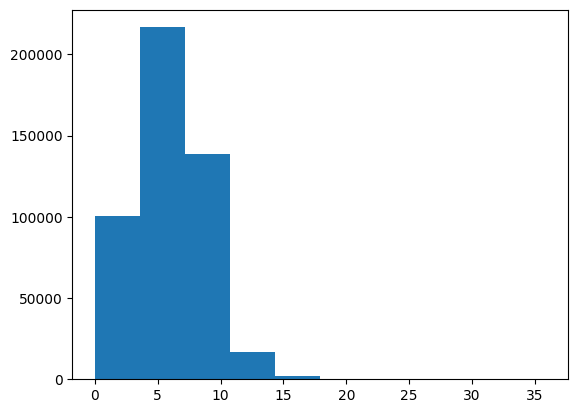

In [71]:
plt.hist(data_vectors[0,:,4].numpy())

In [3]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/debug/v3/fiducial/DESy3_fiducial_???.tfrecord"
# tfr_pattern = "/Users/arne/data/DESY3/tfrecords/debug/v2/DESy3_fiducial_000.tfrecord"

params = ["Om", "s8", "Aia"]
pert_labels = parameters.get_fiducial_perturbation_labels(params)
n_perts = len(pert_labels)
print(n_perts, pert_labels)

n_z_bins = 4

batch_size = 4
examples_shuffle_buffer = 10
n_readers = 1
n_prefetch = 3

7 ['fiducial', 'delta_Om_m', 'delta_Om_p', 'delta_s8_m', 'delta_s8_p', 'delta_Aia_m', 'delta_Aia_p']


In [5]:
fiducial_dset = fiducial_pipeline.get_fiducial_dset(
    tfr_pattern,
    pert_labels,
    batch_size,
    conf=None,
    i_noise=0,
    n_readers=n_readers,
    n_prefetch=n_prefetch,
    examples_shuffle_buffer=examples_shuffle_buffer,
)

23-04-27 14:32:42 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-04-27 14:32:42  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-27 14:32:42  analysis.py INF   Loaded the pixel file 
23-04-27 14:32:42  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-27 14:32:42  analysis.py INF   Loaded the pixel file 


TypeError: 'int' object is not iterable

In [ ]:
t0 = time()
delta_t = []
for x in fiducial_dset.take(100):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)

In [7]:
multi_noise_dset = fiducial_pipeline.get_fiducial_multi_noise_dset(
    tfr_pattern,
    pert_labels,
    batch_size,
    conf=None,
    n_noise=3,
    n_readers=n_readers,
    n_prefetch=n_prefetch,
    examples_shuffle_buffer=examples_shuffle_buffer,
)

23-02-22 12:36:50 fiducial_pip INF   Starting to generate the fiducial training set for i_noise = 0 
23-02-22 12:36:50  analysis.py INF   Loaded the config 
23-02-22 12:36:50  analysis.py INF   Loaded the pixel file 
23-02-22 12:36:50  analysis.py INF   Loaded the config 
23-02-22 12:36:50  analysis.py INF   Loaded the pixel file 
23-02-22 12:36:50 tfrecords.py WAR   Tracing parse_inverse_fiducial 
23-02-22 12:36:50  analysis.py INF   Loaded the config 
23-02-22 12:36:50 fiducial_pip WAR   Tracing dset_add_bias 
23-02-22 12:36:50 fiducial_pip WAR   Tracing dset_add_noise 
23-02-22 12:36:50 fiducial_pip WAR   Tracing dset_concat_perts 
23-02-22 12:36:50 fiducial_pip INF   Successfully generated the fiducial training set with element_spec (TensorSpec(shape=(28, 463872, 4), dtype=tf.float32, name=None), (TensorSpec(shape=(4,), dtype=tf.int64, name=None), TensorSpec(shape=(4,), dtype=tf.int32, name=None))) for i_noise = 0 
23-02-22 12:36:50 fiducial_pip INF   Starting to generate the fiduc

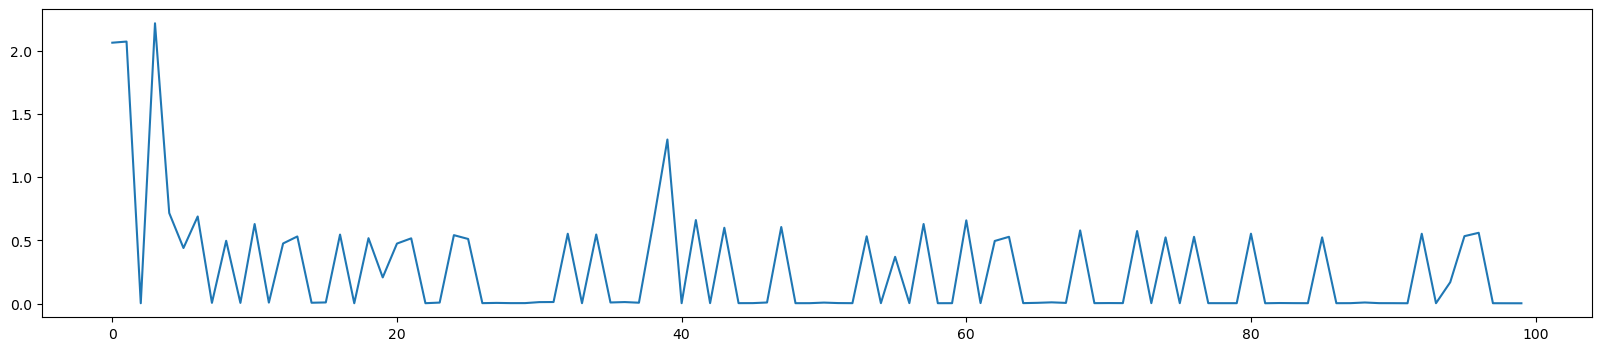

In [8]:
t0 = time()
delta_t = []
for x in multi_noise_dset.take(100):
    t1 = time()
    delta_t.append(t1 - t0)
    t0 = t1

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(delta_t)

### pick an example batch

In [9]:
for x in fiducial_dset.take(1):
    x
    
print(x)

(<tf.Tensor: shape=(28, 463872, 4), dtype=float32, numpy=
array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0

### check the mask

In [12]:
data_vec_pix, _, _, tomo_patches_pix, tomo_corresponding_pix = analysis.load_pixel_file(conf)

kgs = x[0][0]
print(kgs.shape)

print([np.sum(kgs[:,i] != 0) for i in range(4)])
print([len(patches_pix[0]) for patches_pix in tomo_patches_pix])
print([len(patches_pix) for patches_pix in tomo_corresponding_pix])

23-02-22 12:37:52  analysis.py INF   Loaded the config 
23-02-22 12:37:52  analysis.py INF   Loaded the pixel file 
(463872, 4)
[371012, 370979, 370982, 370671]
[371012, 370979, 370982, 370671]
[371012, 370979, 370982, 370671]


# plotting

In [13]:
pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]
    
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

### check the masking

(463872,)
(463872,)
(463872,)
(463872,)


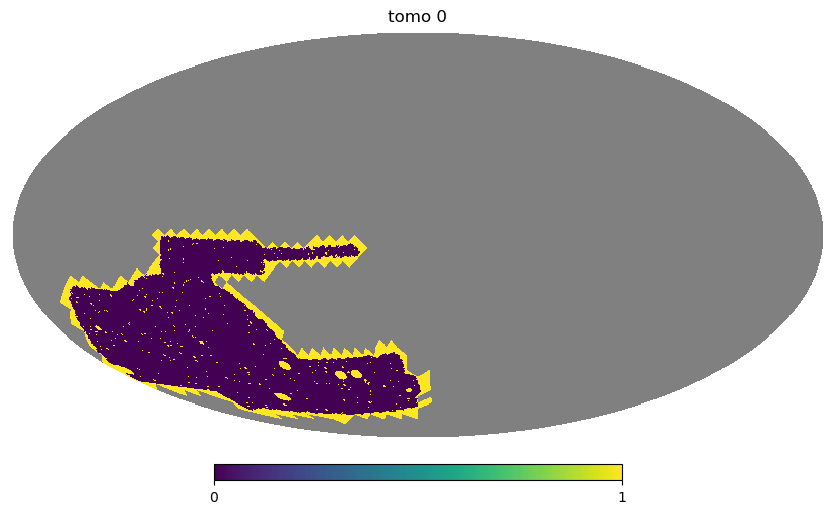

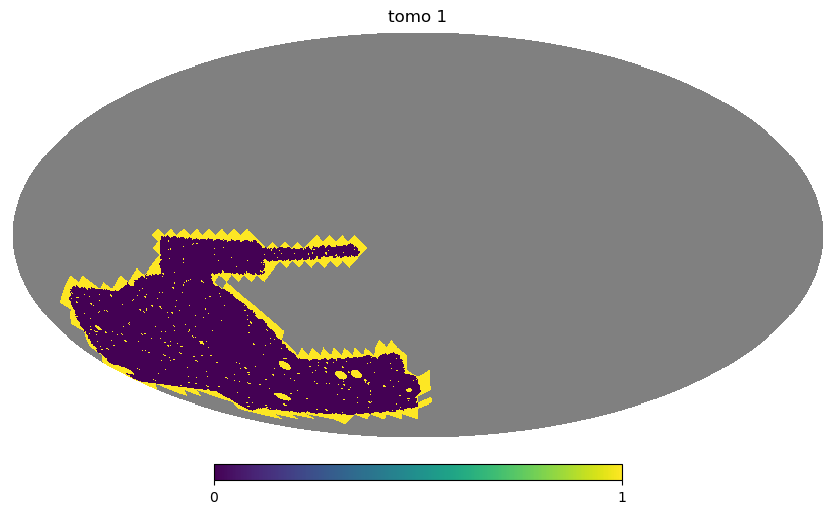

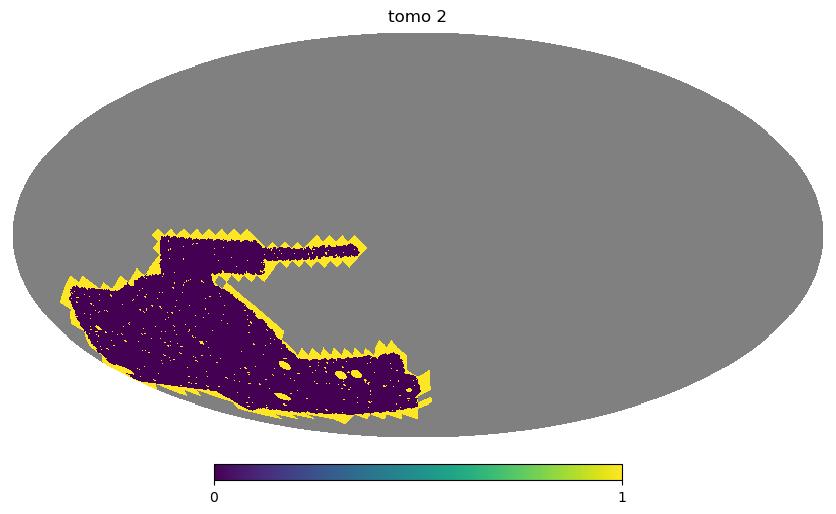

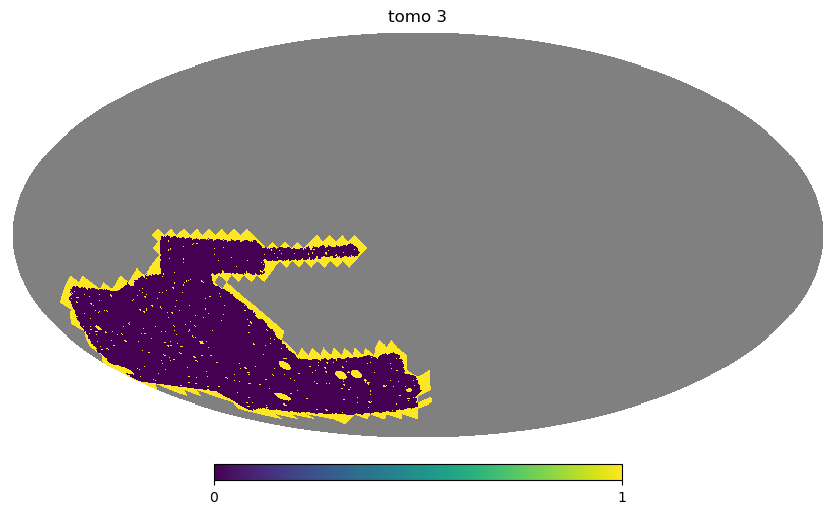

In [14]:
i_pert = 0
for i_tomo in range(n_z_bins):
    kg = x[0].numpy()[i_pert,:,i_tomo]
    print(kg.shape)

    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg

    # hp.mollview(hp_map, nest=True, title=f"tomo {i_tomo}")

    hp_mask = np.full(n_pix, hp.UNSEEN)
    hp_mask[hp_map == 0] = 1
    hp_mask[(hp_map != 0) & (hp_map != hp.UNSEEN)] = 0

    hp.mollview(hp_mask, nest=True, title=f"tomo {i_tomo}")

### check smoothed maps

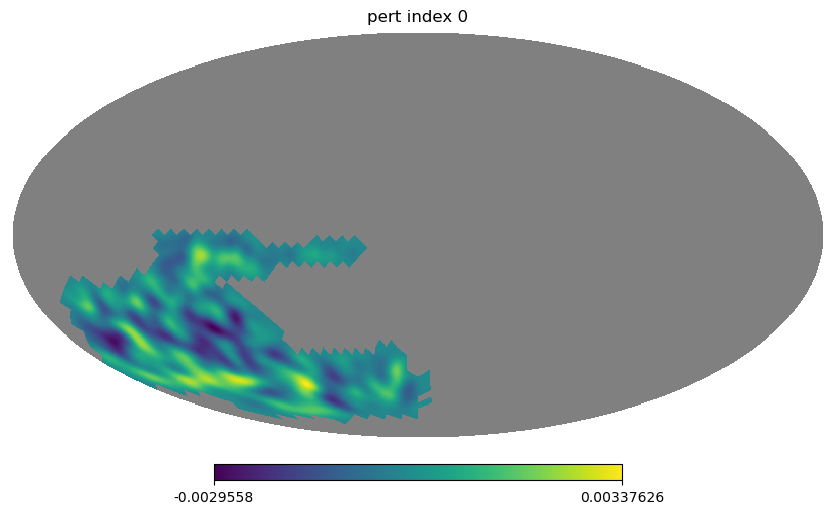

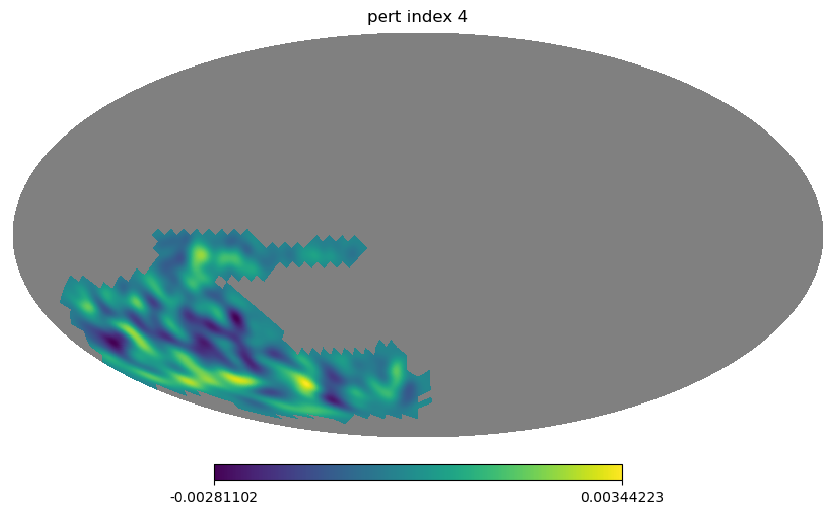

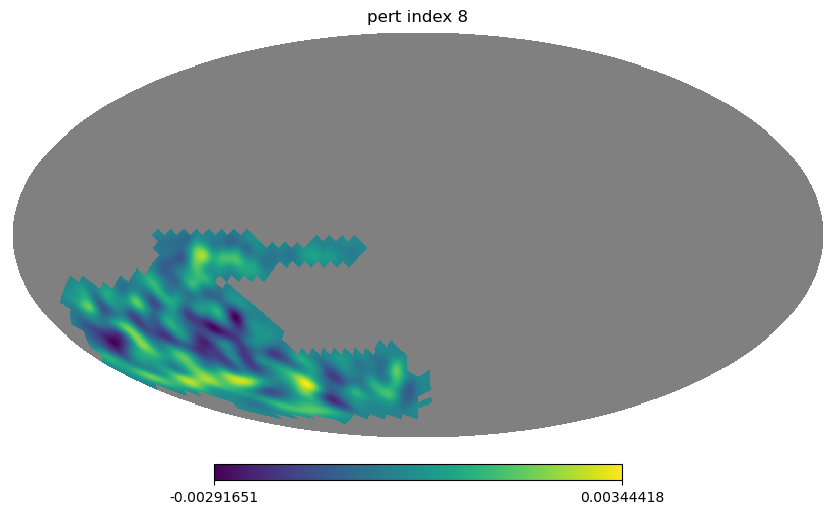

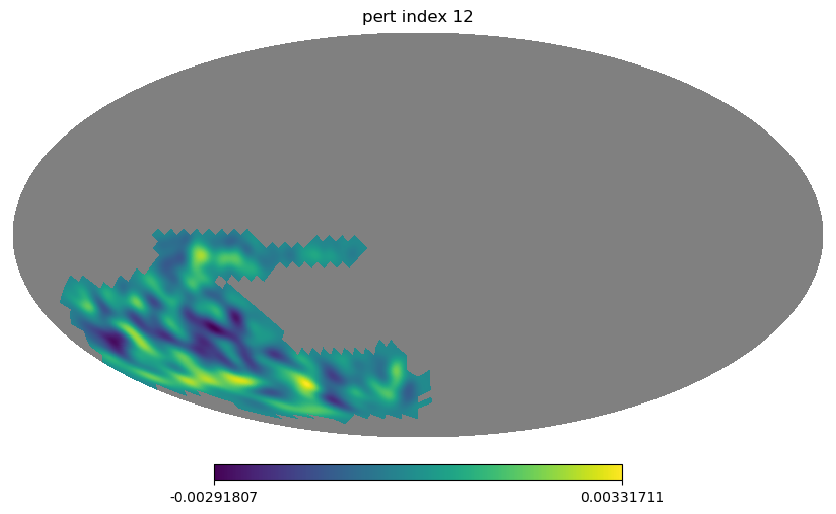

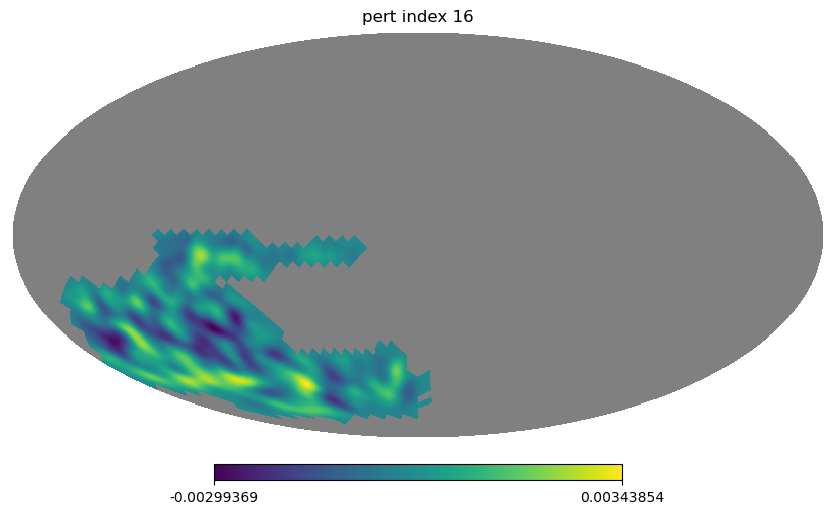

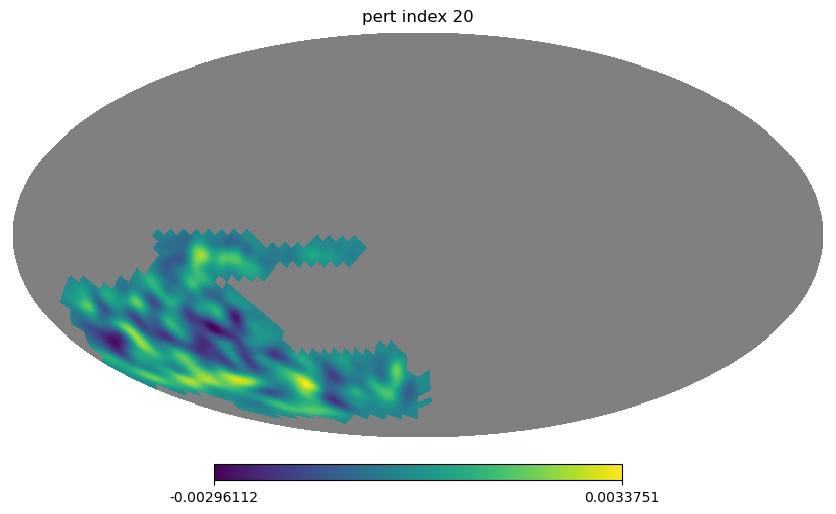

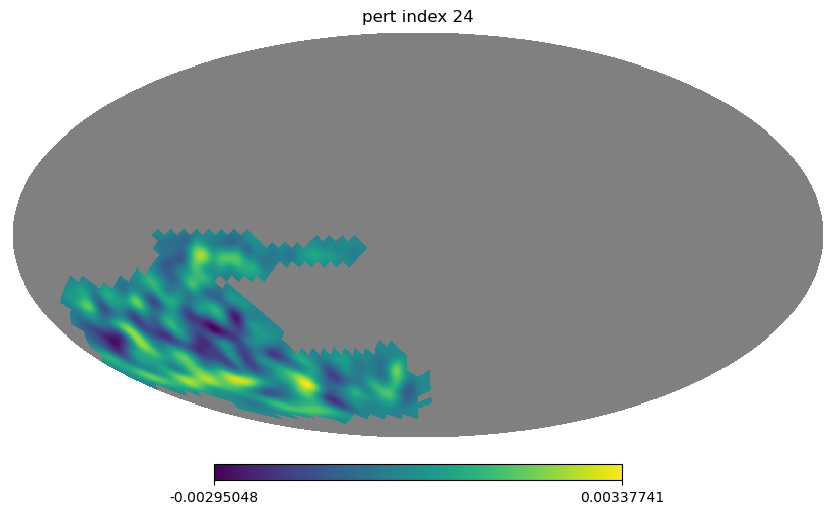

In [15]:
i_tomo = 3

for i_pert in range(0, n_perts*batch_size, batch_size):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = x[0].numpy()[i_pert,:,i_tomo]

    hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
    hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.1)
    hp.mollview(hp_smoothed, title=f"pert index {i_pert}")

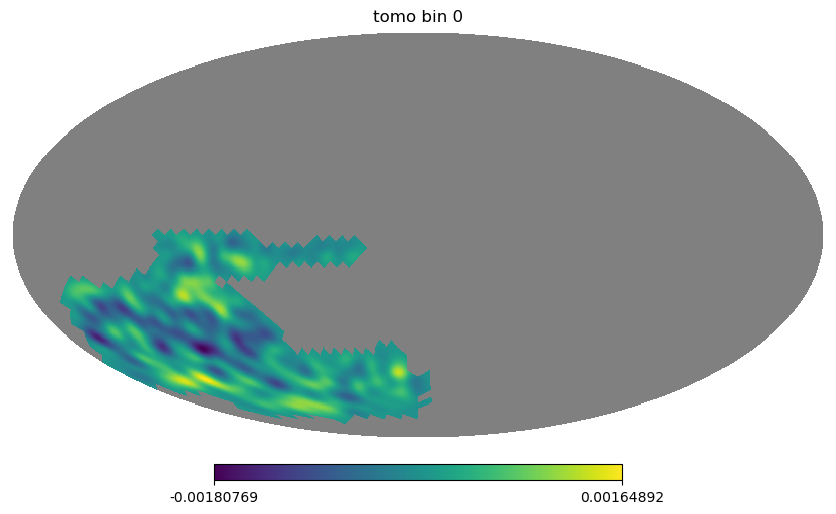

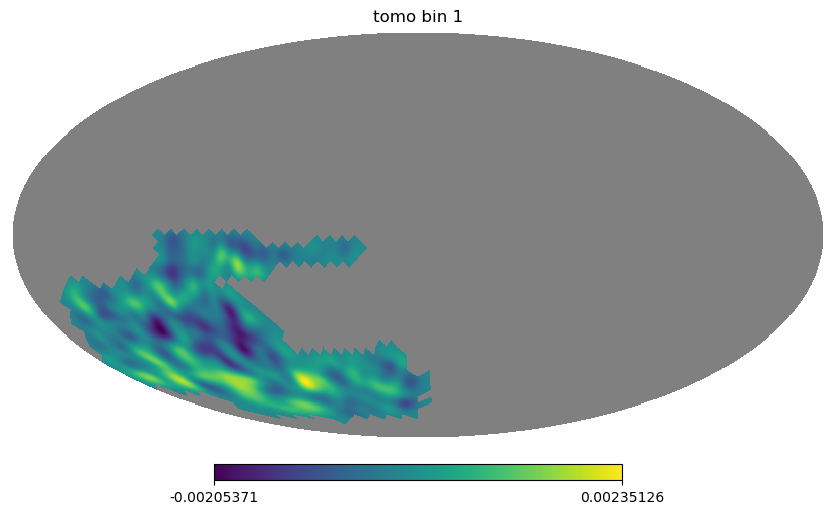

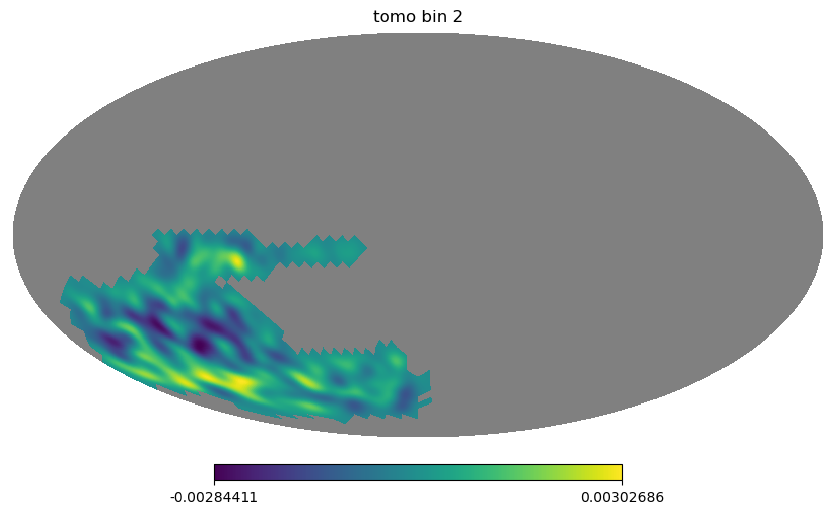

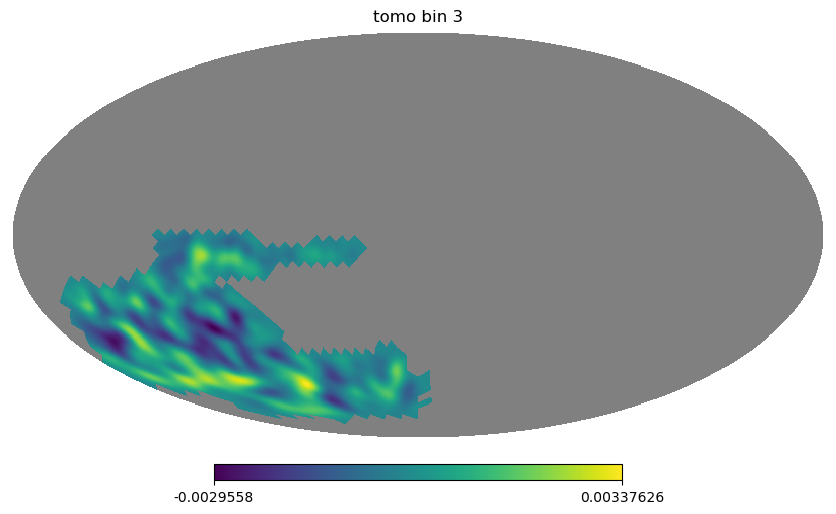

In [16]:
i_pert = 0

for i_tomo in range(n_z_bins):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = x[0].numpy()[i_pert,:,i_tomo]

    hp_map_ring = hp.pixelfunc.reorder(hp_map, inp="NESTED", out="RING")
    hp_smoothed = hp.sphtfunc.smoothing(hp_map_ring, fwhm=0.1)
    hp.mollview(hp_smoothed, title=f"tomo bin {i_tomo}")